# Data Download and Processing

##Mount Google Drive (Google Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

**First visit the NCBI-PubChem and search for Lung Cancer and go to BioAssay and download the CSV files which contains Assay ID with ChEMBL IDs (i.e. CHEMBL695700) and copy the whole column to a new CSV file and add header (chembl_id).**

## SDF Downlading from ChEMBL (Colab)

In [ ]:
import os
import requests
import pandas as pd
from google.colab import files
import shutil

# Upload the CSV file
uploaded = files.upload()

# Load the CSV file with ChEMBL IDs
uploaded_file = next(iter(uploaded))
df = pd.read_csv(uploaded_file)

# Extract ChEMBL IDs from the CSV file
chembl_ids = df['chembl_id'].tolist()

# Define the output directory
output_dir = 'ChEMBL_data'
os.makedirs(output_dir, exist_ok=True)

# Define activity thresholds (you can adjust these as needed)
active_threshold = 5.0  # Example threshold for considering compounds as active

# Create a single directory for all data
all_data_dir = 'All_ChEMBL_data'
os.makedirs(all_data_dir, exist_ok=True)

# Function to download and save SDF file
def download_sdf(compound_id, directory):
    sdf_url = f'https://www.ebi.ac.uk/chembl/api/data/molecule/{compound_id}.sdf'
    response = requests.get(sdf_url)

    if response.status_code == 200:
        with open(os.path.join(directory, f'{compound_id}.sdf'), 'wb') as sdf_file:
            sdf_file.write(response.content)
        return True
    else:
        print(f"Failed to download SDF for compound {compound_id}")
        return False

for i, chembl_id in enumerate(chembl_ids):
    print(f"Processing compound {i+1}/{len(chembl_ids)}")

    # Retrieve compounds for the assay with activity data
    response = requests.get(f'https://www.ebi.ac.uk/chembl/api/data/activity.json?assay_chembl_id={chembl_id}')

    if response.status_code == 200:
        activity_data = response.json()

        for compound in activity_data['activities']:
            # Check if the compound is active based on your threshold
            if compound['standard_value'] is not None and float(compound['standard_value']) <= active_threshold:
                activity = 'Active'
            else:
                activity = 'Inactive'

            compound_id = compound['molecule_chembl_id']

            # Download SDF file
            download_sdf(compound_id, all_data_dir)
            original_file = os.path.join(all_data_dir, f'{compound_id}.sdf')
            new_file_name = f'{activity}_{chembl_id}_{compound_id}.sdf'
            try:
              os.rename(original_file, os.path.join(all_data_dir, new_file_name))
              print(f"Downloaded SDF for {activity} compound {compound_id} in assay {chembl_id}")
            except FileNotFoundError:
              print(f"Failed to rename SDF for {activity} compound {compound_id} in assay {chembl_id}")

print("Download complete, Now saving to your Device")

# Compress the All_ChEMBL_data directory into a ZIP file
shutil.make_archive("/content/All_ChEMBL_data", 'zip', ".", "All_ChEMBL_data")

# Download the ZIP file
files.download("/content/All_ChEMBL_data.zip")

## SDF Downlading from PubChem and ChEMBL (through Jupyter)

In [ ]:
import os
import pandas as pd
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import logging

# Configure logging
logging.basicConfig(filename='compound_fetch_errors.log', level=logging.ERROR)

# Setup requests session with retry strategy
session = requests.Session()
retry_strategy = requests.adapters.Retry(
    total=5,
    backoff_factor=0.3,
    status_forcelist=[500, 502, 503, 504],
    allowed_methods=["HEAD", "GET", "OPTIONS"]
)
adapter = requests.adapters.HTTPAdapter(max_retries=retry_strategy)
session.mount("https://", adapter)
session.mount("http://", adapter)

def fetch_sdf_from_pubchem(cid, dimension='3d'):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/SDF?record_type={dimension}"
    try:
        response = session.get(url, timeout=30)
        response.raise_for_status()
        return response.text, dimension
    except requests.RequestException:
        if dimension == '3d':
            return fetch_sdf_from_pubchem(cid, dimension='2d')
        return None, None

def fetch_sdf_from_chembl(chembl_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{chembl_id}.sdf"
    try:
        response = session.get(url, timeout=30)
        response.raise_for_status()
        return response.text, '2d'  # ChEMBL typically provides 2D structures
    except requests.RequestException:
        return None, None

def download_sdf(compound_name):
    if compound_name.startswith("Molecule"):
        logging.info(f"Not Downloaded: {compound_name}")
        return None, None

    if compound_name.startswith("Active_"):
        chembl_id = compound_name.split('_')[-1]
        if chembl_id.startswith("CHEMBL"):
            return fetch_sdf_from_chembl(chembl_id)

    if compound_name[0].isdigit():
        return fetch_sdf_from_pubchem(compound_name)

    return None, None

def save_sdf(name, sdf, output_dir, score, dimension):
    if sdf:
        file_path = os.path.join(output_dir, f"{name}_act_{score}_{dimension}.sdf")
        with open(file_path, 'w') as f:
            f.write(sdf)

def process_compounds(compounds, output_dir):
    not_downloaded = []
    os.makedirs(output_dir, exist_ok=True)

    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(download_sdf, name): name for name in compounds}

        for future in tqdm(futures, total=len(futures), desc=f"Downloading SDF files"):
            compound_name = futures[future]
            try:
                sdf, dimension = future.result()
                if sdf:
                    score = compounds[compound_name]
                    save_sdf(compound_name, sdf, output_dir, score, dimension)
                else:
                    not_downloaded.append(compound_name)
                    logging.info(f"Not Downloaded: {compound_name}")
            except Exception as e:
                logging.error(f"Error downloading {compound_name}: {e}")
                not_downloaded.append(compound_name)

    if not_downloaded:
        log_file = os.path.join(output_dir, "not_downloaded.txt")
        with open(log_file, 'w') as f:
            f.write("\n".join(not_downloaded))

def get_score_range():
    min_score = float(input("Enter the minimum score: "))
    max_score = float(input("Enter the maximum score: "))
    return min_score, max_score

def main():
    # Load the file with compound names
    input_file = '/home/shaban/Desktop/ChEMBL-PubChem/ResNet_FNN_RNN_Average_Majority_Stacking/Predicted_Activity_New_Drug_Library_All_Models.csv'
    df = pd.read_csv(input_file)

    # Ask user for the score range to download compounds from PubChem and ChEMBL
    min_score, max_score = get_score_range()

    # Define the models and their respective activity score columns
    models = ['ResNet', 'RNN', 'FNN', 'Ensemble_Avg', 'Ensemble_Majority', 'Ensemble_Stacking']
    score_columns = ['ResNet_Activity', 'RNN_Activity', 'FNN_Activity', 'Ensemble_Activity_Avg', 'Ensemble_Activity_Majority', 'Ensemble_Activity_Stacking']

    # Fetch and save compound data from PubChem and ChEMBL for each model within the score range
    for model_name, score_column in zip(models, score_columns):
        compounds_in_range = df[(df[score_column] >= min_score) & (df[score_column] <= max_score)]
        filtered_compounds = compounds_in_range[~compounds_in_range['NAME'].str.startswith("Molecule")]

        compound_dict = {row['NAME']: row[score_column] for _, row in filtered_compounds.iterrows()}

        output_dir = f"Downloaded_Structures-TEST3/{model_name}"
        process_compounds(compound_dict, output_dir)

if __name__ == "__main__":
    main()

##Printing list of 3D and 2D Structures separately to verify them

In [ ]:
#Printing list of 3D and 2D Structures separately.
import os
from rdkit import Chem

# Directory containing SDF files
directory_path = 'C:/Users/Shaba/Desktop/1/All_ChEMBL_data/'

# Lists to store 2D and 3D structure files
sdf_2d_files = []
sdf_3d_files = []

# List all SDF files in the directory
sdf_files = [f for f in os.listdir(directory_path) if f.endswith('.sdf')]

for sdf_file in sdf_files:
    sdf_file_path = os.path.join(directory_path, sdf_file)

    # Load the SDF file
    suppl = Chem.SDMolSupplier(sdf_file_path)

    # Check if the first molecule is 2D or 3D
    molecule = next(suppl, None)  # Use next() to avoid a StopIteration error
    if molecule is not None and molecule.GetNumConformers() > 0:
        sdf_3d_files.append(sdf_file)
        #print("This is the 3D Files", sdf_file)
    else:
        sdf_2d_files.append(sdf_file)
        #print("This is the 2D Files", sdf_file)

#print("Files with 3D structures:")
#for file in sdf_3d_files:
   # print(file)

print("\nFiles with 2D structures:")
for file in sdf_2d_files:
    print(file)

## Removing Unnecessary Content in SDF File to import it in any software

In [ ]:
import os
from rdkit import Chem
from rdkit.Chem import AllChem

# Define the directory where your SDF files are located
input_directory = 'C:/Users/Shaba/Desktop/1/All_ChEMBL_data/'
output_directory = 'C:/Users/Shaba/Desktop/1/Updated Data/'

# Iterate over SDF files in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.sdf'):
        input_sdf = os.path.join(input_directory, filename)
        output_sdf = os.path.join(output_directory, filename)

        # Create a writer for the output SDF file
        writer = Chem.SDWriter(output_sdf)

        # Iterate over compounds in the input SDF file
        suppl = Chem.SDMolSupplier(input_sdf)
        for mol in suppl:
            if mol is not None:
                # Remove the <chembl_pref_name> tag
                if '<chembl_pref_name>' in mol.GetPropsAsDict():
                    mol.ClearProp('<chembl_pref_name>')

                # Update the molecule's properties and write it to the output SDF file
                writer.write(mol)

        # Close the output SDF file
        writer.close()

print("Processing complete. Modified SDF files are saved in the output directory.")

## Merge Active and Inactive Compounds to make Library
Keep all the Downloaded data in single directory and merge them to make a one file for active and one file for inactive

In [ ]:
#Merging the ACTIVE Compounds
#Note IT WILL SAVE THE FILE WHERE PYTHON FILE IS SAVED

import os
from rdkit import Chem
from rdkit.Chem import SDWriter

# Directory where your SDF files are located
input_directory = 'C:/Users/Shaba/Desktop/11/'
output_file = 'Active_ChEMBL_Lung_Cancer_1.sdf'
active_compounds = 0

# Initialize an SDWriter for the output file
output_writer = SDWriter(output_file)

# Iterate through the files in the directory
for filename in os.listdir(input_directory):
    if filename.startswith('Active_'):
        # Open the SDF file
        suppl = Chem.SDMolSupplier(os.path.join(input_directory, filename))
        for mol in suppl:
            if mol is not None:
                output_writer.write(mol)
                active_compounds += 1

# Close the output writer
output_writer.close()

# Rename the output file to include the count of active compounds
output_file_with_count = f'Active_ChEMBL_Lung_Cancer_{active_compounds}.sdf'

# Check if the file with the new name already exists and delete it if it does
if os.path.exists(output_file_with_count):
    os.remove(output_file_with_count)

os.rename(output_file, output_file_with_count)

print(f'{active_compounds} active compounds have been merged into {output_file_with_count}')
print("DONE")


In [ ]:
#Merging the INACTIVE Compounds

import os
from rdkit import Chem
from rdkit.Chem import SDWriter

# Directory where your SDF files are located
input_directory = 'C:/Users/Shaba/Desktop/Folder/'
output_file = 'C:/Users/Shaba/Desktop/Folder/1_Inactive_ChEMBL_Lung_Cancer_1.sdf'
inactive_compounds = 0

# Initialize an SDWriter for the output file
output_writer = SDWriter(output_file)

# Iterate through the files in the directory
for filename in os.listdir(input_directory):
    if filename.startswith('Inactive_'):
        # Open the SDF file
        suppl = Chem.SDMolSupplier(os.path.join(input_directory, filename))
        for mol in suppl:
            if mol is not None:
                # Set the title of the compound to the filename without the extension
                # This will use the filename as the title
                mol.SetProp('_Name', os.path.splitext(filename)[0])
                output_writer.write(mol)
                inactive_compounds += 1

# Close the output writer
output_writer.close()

# Rename the output file to include the count of active compounds
output_file_with_count = f'1_Inactive_ChEMBL_Lung_Cancer_{active_compounds}.sdf'

# Check if the file with the new name already exists and delete it if it does
if os.path.exists(output_file_with_count):
    os.remove(output_file_with_count)

os.rename(output_file, output_file_with_count)

print(f'{inactive_compounds} inactive compounds have been merged into {output_file_with_count}')

print("DONE")

## Remove Duplicates in SDF

In [ ]:
pip install rdkit-pypi

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import SDMolSupplier, SDWriter

def remove_duplicates(input_sdf, output_sdf):
    # Load the SDF file
    suppl = SDMolSupplier(input_sdf)

    # Initialize a set to store unique structures
    unique_structures = set()

    # Create a new SDF file for writing unique structures
    writer = SDWriter(output_sdf)

    # Define a salt remover to remove salts if needed
    remover = SaltRemover()

    # Iterate through each molecule in the SDF file
    for mol in suppl:
        if mol is not None:
            # Remove salts if necessary
            mol = remover.StripMol(mol)

            # Generate a canonical SMILES representation
            canonical_smiles = Chem.MolToSmiles(mol, canonical=True)

            # Check if the structure is unique
            if canonical_smiles not in unique_structures:
                unique_structures.add(canonical_smiles)

                # Write the unique structure to the output SDF file
                writer.write(mol)

    # Close the output SDF file
    writer.close()

# Example usage
input_sdf_file = "C:Active_ChEMBL_18349_3D_ligprep_Activity.sdf"
output_sdf_file = "C:Active_ChEMBL_18349_3D_ligprep_Activity_output_unique.sdf"
remove_duplicates(input_sdf_file, output_sdf_file)
print("Saved")

##Add Activity in the compound, Active =1 and inactive =0

In [ ]:
#ACTIVE
#input file
fin = open("C:/Users/Shaba/Desktop/Active_ChEMBL_18349_3D_ligprep.sdf", "rt")
#output file to write the result to
fout = open("C:/Users/Shaba/Desktop/Active_ChEMBL_18349_3D_ligprep_Activity.sdf", "wt")
#for each line in the input file
for line in fin:
	#read replace the string and write to output file
	fout.write(line.replace('$$$$', '> <Activity>\n1\n\n$$$$'))
#close input and output files
fin.close()
fout.close()

print("Done")

In [ ]:
#INACTIVE
#input file
fin = open("C:/Users/Shaba/Desktop/Inactive_PubChem_301121.sdf", "rt")
#output file to write the result to
fout = open("C:/Users/Shaba/Desktop/Inactive_PubChem_301121_Activity.sdf", "wt")
#for each line in the input file
for line in fin:
	#read replace the string and write to output file
	fout.write(line.replace('$$$$', '> <Activity>\n0\n\n$$$$'))
#close input and output files
fin.close()
fout.close()

print("Done")

The Descriptors can be computed usign PaDel, QikProp, and AlvaDesc software
Merge all Descriptors to make a single File, removing duplicates etc for making final files for the data processing

##Add Acitivity column to CSV (Active =1 Inactive =0) if not done in the SDF file


In [ ]:
import csv

input_file = 'C:\Users\Shaba\Desktop\1. PhD\01. PubChem\Descriptors_PubChem_Inactive.txt'
output_file = 'C:\Users\Shaba\Desktop\1. PhD\01. PubChem\Descriptors_PubChem_Inactive_Activity.txt'

# Open the input and output files
with open(input_file, 'r', newline='') as infile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(infile, delimiter='\t')
    writer = csv.writer(outfile, delimiter='\t')

    # Process the header row
    header = next(reader)
    header.insert(header.index('NAME') + 1, 'Activity')

    # Write the modified header to the output file
    writer.writerow(header)

    # Process the rest of the rows
    for row in reader:
        row.insert(header.index('NAME') + 1, '0')
        writer.writerow(row)

print("Added 'Activity' column with 0 values and saved the modified TSV file.")

In [ ]:
#Convert TSV to CSV

import csv

with open(r'C:\Users\Shaba\Desktop\1. PhD\01. PubChem\Descriptors_PubChem_Inactive_Activity.txt', 'r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    with open(r'C:\Users\Shaba\Desktop\1. PhD\01. PubChem\Descriptors_PubChem_Inactive_Activity.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in reader:
            writer.writerow(row)

print("The file is converted and saved")

## Files Merging

In [ ]:
#Combine Two Files  FINAL
import pandas as pd

# Ensure you provide the correct file paths and close the string with a single quote
df1 = pd.read_csv('C:Desciptors_ChEMBL_Inactive_Activity_QikProp_MACCS.csv')
df2 = pd.read_csv('C:ECFP_1024_m0-2_b2_c_table.csv')
combined_df = pd.concat([df1, df2], axis=1)
combined_df.to_csv('02_ChEMBL_inactive_Activity_Desciptors_QikProp_MACCS-FP_ECFP.csv', index=False)

print("Both files are merged and saved")

In [ ]:
#Combining the files by taking chunks

import pandas as pd

# Specify the chunk size
chunk_size = 5000  # You can adjust this value as needed

# Define the file paths
file1 = '/home/shaban/Desktop/Descriptors_ChEMBL_Inactive_Activity_QikProp_MACCS.csv'
file2 = '/home/shaban/Desktop/ECFP_1024_m0-2_b2_c_table.csv'

# Create an iterator to read the CSV files in chunks
reader1 = pd.read_csv(file1, chunksize=chunk_size)
reader2 = pd.read_csv(file2, chunksize=chunk_size)

# Create the output file and write the header
with open('/home/shaban/Desktop/02_ChEMBL_inactive_Activity_Desciptors_QikProp_MACCS-FP_ECFP.csv', 'w') as output_file:
    header_written = False  # To write the header only once

    for chunk1, chunk2 in zip(reader1, reader2):
        # Merge the two chunks
        merged_chunk = pd.concat([chunk1, chunk2], axis=1)

        # Write the merged chunk to the output file
        if not header_written:
            merged_chunk.to_csv(output_file, index=False)
            header_written = True
        else:
            merged_chunk.to_csv(output_file, index=False, header=False)

print("Both files are merged and saved in chunks to manage memory.")


In [ ]:
# Merge Huge File size

import pandas as pd

# Define the file paths
file1 = '/home/shaban/Desktop/1_Descriptors_PubChem_Inactive_Activity_QikProp_MACCS.csv'
file2 = '/home/shaban/Desktop/2_ECFP_1024_m0-2_b2_c_table.csv'

# Output file path
output_file = '/media/shaban/DATA/ShabanAhmad/02_02_Descriptors_PubChem_Inactive_Activity_QikProp_MACCS_ECFP.csv'

# Read the header of both files
with open(file1, 'r') as f1, open(file2, 'r') as f2:
    header1 = next(f1)
    header2 = next(f2)

# Combine the headers into a single header
combined_header = header1.strip() + ',' + header2

# Initialize flags to skip the first line of each file
skip1 = True
skip2 = True

# Open the output file for writing
with open(output_file, 'w') as output:
    # Write the combined header to the output file
    output.write(combined_header)

    # Open and read the first file
    with open(file1, 'r') as f1:
        for line in f1:
            if skip1:
                skip1 = False
                continue
            output.write(line)
            print("File is written, Now started with File 2")
    # Open and read the second file
    with open(file2, 'r') as f2:
        for line in f2:
            if skip2:
                skip2 = False
                continue
            output.write(','.join([''] * len(header1.split(','))) + ',' + line)


print("Both CSV files are merged with continuous columns in a single file to manage memory.")

## Change any value in the CSV File (SNo to No)

In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("C:01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_ECFP.csv", low_memory=False)

# Rename the "SNo" column to "No"
df = df.rename(columns={"SNo.": "No."})

# Save the DataFrame back to a CSV file
df.to_csv("C:01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_ECFP_.csv", index=False)

# Print a message to confirm the update
print("The 'SNo' column has been renamed to 'No' and saved to '01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_ECFP_.csv'.")

C:\Users\Shaba\AppData\Local\Temp\ipykernel_17500\488810925.py:4: DtypeWarning: Columns (5720) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_ECFP.csv")


The 'SNo' column has been renamed to 'No' and saved to '01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_ECFP_.csv'.


##Write header to a different CSV File to verify them all together

In [ ]:
import pandas as pd

# List of file names
file_names = [
    "C:01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_ECFP.csv",
    "C:02_ChEMBL_Inactive_Activity_Desciptors_QikProp_MACCS-FP_ECFP.csv",
    "C:01_PubChem_Active_Activity_Desciptors_QikProp_MACCS-FP_ECFP.csv",
    "C:02_PubChem_Inactive_Activity_Desciptors_QikProp_MACCS-FP_ECFP.csv"
]

for file_name in file_names:
    # Read the first row (header) of the CSV file
    with open(file_name, 'r') as file:
        header = file.readline().strip().split(',')

    # Create a CSV file with the header
    header_csv_name = f"{file_name}_header.csv"
    with open(header_csv_name, 'w') as header_file:
        header_file.write('\n'.join(header))

    print(f"The header of the {file_name} is saved in {header_csv_name}.")


## Remove FORMULA and NAME.1 column

In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
file_name = "C:01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE.csv"
df = pd.read_csv(file_name)

# Check for the "FORMULA" and "NAME.1" columns in a case-insensitive manner
columns_lower = [col.lower() for col in df.columns]
columns_to_drop = ["FORMULA", "NAME.1"]

for column_to_drop in columns_to_drop:
    if column_to_drop.lower() in columns_lower:
        # Drop the column with the case-insensitive name
        df = df.drop(columns=[df.columns[columns_lower.index(column_to_drop.lower())]])

# Save the DataFrame to a new CSV file without the specified columns
new_file_name = "C:01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_FINAL.csv"
df.to_csv(new_file_name, index=False)

print(f"The 'FORMULA' and 'NAME.1' columns have been removed, and the data is saved to {new_file_name}.")

C:\Users\Shaba\AppData\Local\Temp\ipykernel_17500\3059727774.py:5: DtypeWarning: Columns (5720) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name)


The 'FORMULA' and 'NAME.1' columns have been removed, and the data is saved to C:01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_ECFP_.csv.


## Taking the same data size from Active and Inactive

In [ ]:
#ChEMBL

import pandas as pd

# Load the Active compounds data
active_file_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/01_ChEMBL_Active_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL.csv'
inactive_file_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/02_ChEMBL_Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL.csv'
output_file_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/03_ChEMBL_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA.csv'

active_df = pd.read_csv(active_file_path)
inactive_df = pd.read_csv(inactive_file_path)

# Check the number of rows in the Active data
num_rows_active = active_df.shape[0]

# Select the same number of rows from the Inactive data
inactive_subset_df = inactive_df.sample(n=num_rows_active, random_state=1)

# Combine both dataframes
combined_df = pd.concat([active_df, inactive_subset_df], ignore_index=True)

# Write the combined dataframe to a new CSV file
combined_df.to_csv(output_file_path, index=False)

print(f"Active data rows: {num_rows_active}")
print(f"Inactive data rows taken: {num_rows_active}")
print(f"Combined data saved to: {output_file_path}")


Active data rows: 4537
Inactive data rows taken: 4537
Combined data saved to: /home/shaban/Desktop/ChEMBL-PubChem/Dataset/03_ChEMBL_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA.csv


In [ ]:
#PubChem
import pandas as pd

# Load the Active compounds data
active_file_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/01_PubChem_Active_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL.csv'
inactive_file_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/02_PubChem_Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_.csv'
output_file_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/03_PubChem_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA.csv'

active_df = pd.read_csv(active_file_path)
inactive_df = pd.read_csv(inactive_file_path)

# Check the number of rows in the Active data
num_rows_active = active_df.shape[0]

# Select the same number of rows from the Inactive data
inactive_subset_df = inactive_df.sample(n=num_rows_active, random_state=1)

# Combine both dataframes
combined_df = pd.concat([active_df, inactive_subset_df], ignore_index=True)

# Write the combined dataframe to a new CSV file
combined_df.to_csv(output_file_path, index=False)

print(f"Active data rows: {num_rows_active}")
print(f"Inactive data rows taken: {num_rows_active}")
print(f"Combined data saved to: {output_file_path}")

/tmp/ipykernel_1217400/3180559213.py:9: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  inactive_df = pd.read_csv(inactive_file_path)


Active data rows: 8661
Inactive data rows taken: 8661
Combined data saved to: /home/shaban/Desktop/ChEMBL-PubChem/Dataset/03_PubChem_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA.csv


## Merging the ChEMBL-PubChem file

In [ ]:
import pandas as pd

# File paths for the two files to merge
file1_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/03_ChEMBL_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA.csv'
file2_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/03_PubChem_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA.csv'
output_file_path = '/home/shaban/Desktop/ChEMBL-PubChem/Dataset/04_ChEMBL-PubChem_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA-MERGED.csv'

# Read the two CSV files into DataFrames
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

# Concatenate the DataFrames
merged_df = pd.concat([df1, df2], ignore_index=True)

# Write the merged DataFrame to a new CSV file
merged_df.to_csv(output_file_path, index=False)

print(f"Merged data saved to: {output_file_path}")

Merged data saved to: /home/shaban/Desktop/ChEMBL-PubChem/Dataset/04_ChEMBL-PubChem_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA-MERGED.csv


#--------------------------------------------------------------------------------------------------

# Deep Learning

## ResNet

2024-05-27 10:38:29.019259: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 10:38:29.063013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 10:38:29.063057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 10:38:29.064674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 10:38:29.072204: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 10:38:29.073086: I tensorflow/core/platform/cpu_feature_guard.cc:1

The PCA-based dimensionality reduction has identified and saved two files for top 5883 descriptors and all descriptors with their importance.
Columns 'NAME' and 'Source' dropped from the dataset.


2024-05-27 10:40:18.054016: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6784 - loss: 1.0354 - val_accuracy: 0.9102 - val_loss: 0.3017
Epoch 2/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9212 - loss: 0.2504 - val_accuracy: 0.8809 - val_loss: 0.5246
Epoch 3/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9353 - loss: 0.2223 - val_accuracy: 0.9545 - val_loss: 0.1867
Epoch 4/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9721 - loss: 0.1065 - val_accuracy: 0.8881 - val_loss: 0.4931
Epoch 5/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9554 - loss: 0.1722 - val_accuracy: 0.9706 - val_loss: 0.1193
Epoch 6/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9830 - loss: 0.0651 - val_accuracy: 0.9676 - val_loss: 0.1286
Epoch 7/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9832 - loss: 0.0638 - val_accuracy: 0.9801 - val_loss: 0.0921
Epoch 8/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9854 - loss: 0.0573 - val_accuracy: 0.

Model saved successfully.
The testing & training sets are saved to validate.
Time taken to train the ResNet model: 192.30188727378845 seconds
Accuracy (ResNet): 0.9918560606060606


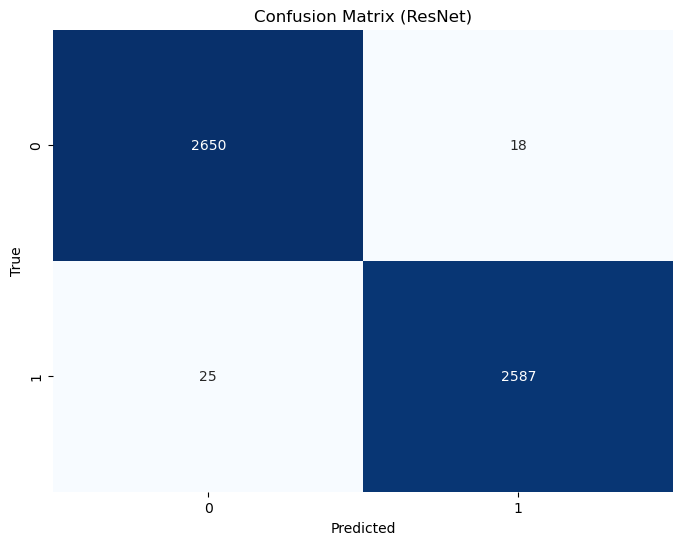

The confusion matrix for ResNet is saved.
ROC AUC (ResNet): 0.9918410817562122


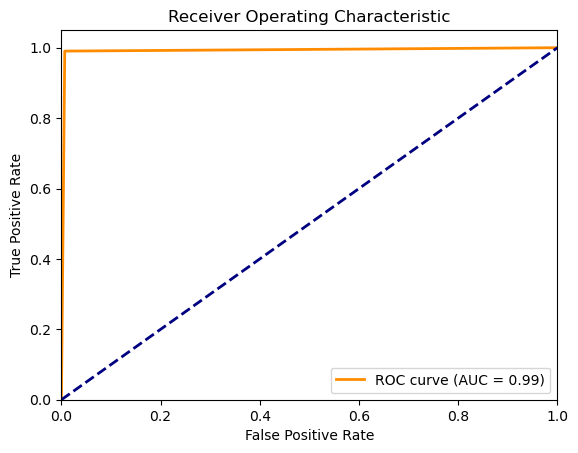

The ROC curve for ResNet is saved.
Mean accuracy for 5-fold CV: 0.9724378466606141, Std Deviation 5-Fold: 0.010613090148713802
Mean accuracy for 10-fold CV: 0.9771729588508606, Std Deviation 10-Fold: 0.007409635424506811
Combined Std Deviation: 0.008895515756500005


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


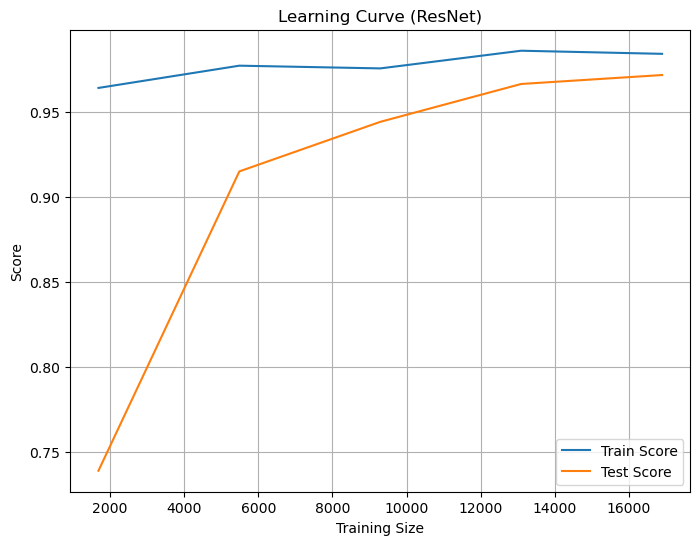

The learning curve for ResNet is saved.
Total elapsed time for running the whole code (ResNet): 1264.8235104084015 seconds
The epochs output is saved.


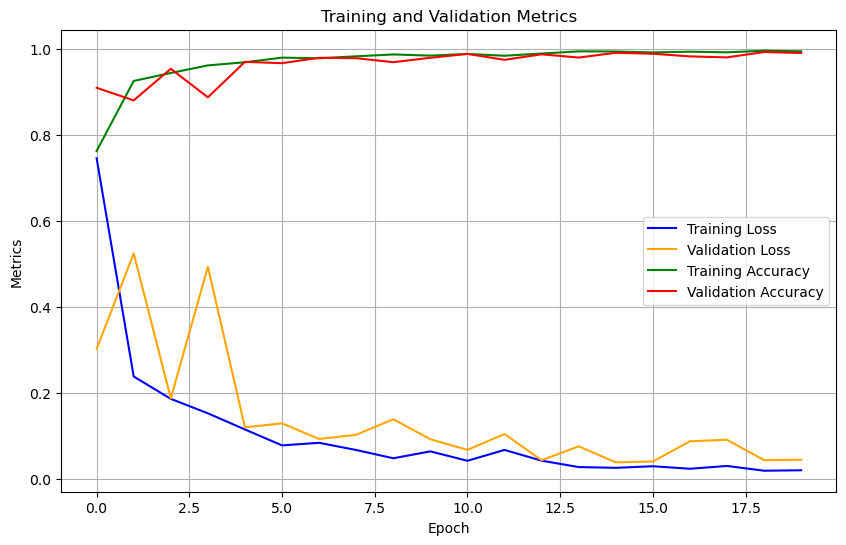

Precision (ResNet): 0.9930902111324377
Recall (ResNet): 0.9904287901990811
F1 Score (ResNet): 0.9917577151619705

 
 
#####################################################################################
##################  ALL METRICS ARE COMPUTED AND SAVED SUCCESSFULLY  ###############
#####################################################################################
 
 

 
 
#####################################################################################
##################  HERE ARE ALL THE COMPUTED METRICS ############################### 
                          Metrics        Value
0            ResNet Elapsed Time   192.301887
1                       Accuracy     0.991856
2                      Precision     0.993090
3                         Recall     0.990429
4                       F1 Score     0.991758
5                      AUC Score     0.991841
6                    Sensitivity     0.990429
7                    Specificity     0.993253
8         Mean Accuracy (5-F

In [ ]:
##################################################################################################################
# IMPORT THE NECESSARY LIBRARIES
##################################################################################################################
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from keras.models import Model
from keras.layers import Input, Dense, Add
from keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.callbacks import EarlyStopping
import os
start_time = time.time()

##################################################################################################################
# LOAD THE DATASET AND PCA TO RANK THE DESCRIPTORS
##################################################################################################################

# Load your CSV file into a data frame (assuming the descriptors are in columns)
original_data = pd.read_csv('/home/shaban/Desktop/ChEMBL-PubChem/Dataset/04_ChEMBL-PubChem_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA-MERGED.csv', low_memory=False)

# Use 'Activity' as the target variable
target_column = 'Activity'

# Replace 'na' values with NaN
original_data = original_data.replace('na', np.nan)

# Assuming the target variable is in a column with the specified name
X = original_data.drop(target_column, axis=1)
y = original_data[target_column]

# Convert each column to numeric, replacing non-convertible values with NaN
for column in X.columns:
    X[column] = pd.to_numeric(X[column], errors='coerce')

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the original_data before applying PCA
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_imputed)

# Create a PCA model with the number of components you desire
n_components = 5883  # You can change this value to the number of top descriptors you want
pca = PCA(n_components=n_components)

# Fit the PCA model on your original_data
X_pca = pca.fit_transform(X_standardized)

# Get the absolute values of the principal components
abs_components = np.abs(pca.components_)

# Create a data Frame to store feature names and their importance values
descriptor_names = X.columns  # Get the descriptor names from column headers
num_components_used = min(n_components, len(descriptor_names))  # Ensure we don't exceed the number of available descriptors

# Extract only the top components used to match the number of descriptors
abs_components_used = abs_components[:, :num_components_used]

# Create a data Frame with the selected number of components
feature_pca_df = pd.DataFrame({'Descriptor': descriptor_names[:num_components_used], 'Importance': abs_components_used.sum(axis=0)})

# Sort the descriptors by their importance
feature_pca_df = feature_pca_df.sort_values(by='Importance', ascending=False)

# Add 'Activity' feature with an importance value of 0
activity_feature = pd.DataFrame({'Descriptor': ['Activity'], 'Importance': [1]})
feature_pca_df = pd.concat([feature_pca_df, activity_feature], ignore_index=True)

# Save all the descriptors with their importance values to another CSV file
feature_pca_df.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/Dataset/06_PCA-ResNet.csv', index=False)

print("The PCA-based dimensionality reduction has been saved")

# Extract feature names

selected_features = feature_pca_df['Descriptor'].tolist()

# Filter columns based on selected features and convert non-numeric values to NaN
selected_data = original_data[selected_features].apply(pd.to_numeric, errors='coerce')

# Drop columns with headers 'NAME' or 'Source'
selected_data = selected_data.drop(columns=['NAME', 'Source'], errors='ignore')
print("Columns 'NAME' and 'Source' dropped from the dataset.")

# Ensure the target column 'Activity' exists in the original dataset
if 'Activity' not in original_data.columns:
    raise KeyError("The target column 'Activity' is not present in the original dataset.")

# Define 'X' and 'y' for Train-Test Split
X = selected_data  # Assuming 'selected_data' contains all features
y = original_data['Activity']  # Assuming 'Activity' is the name of the target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy arrays
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

##################################################################################################################
# ResNet TRAINING
##################################################################################################################

# Define the ResNet model
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(50, activation='relu')(input_layer)
x = Dense(50, activation='relu')(x)
residual = Dense(50, activation='relu')(input_layer)  # Residual connection
x = Add()([x, residual])
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])
elapsed_time_resnet = time.time() - start_time

# Predict on the test set
y_pred_resnet = model.predict(X_test_scaled)
y_pred_resnet = (y_pred_resnet > 0.5).astype(int)

model.save('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/1_ResNet_Model.h5')
print("Model saved successfully.")

##################################################################################################################
# CHECK WHAT HAVE BEEN USED FOR THE TRAINING AND TESTING
##################################################################################################################
# Create DataFrames for training and testing samples
training_samples = X_train
testing_samples = X_test

# Save testing and Training samples to a CSV file
training_samples.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/2_ResNet_training_samples.csv', index=False)
testing_samples.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/3_ResNet_testing_samples.csv', index=False)
print("The testing & training sets are saved to validate.")

##################################################################################################################
# CHECK AND VALIDATE THE OUTPUTS
##################################################################################################################

# 1. Elapsed Time
print(f"Time taken to train the ResNet model: {elapsed_time_resnet} seconds")

# 2. Calculate accuracy
accuracy_resnet = accuracy_score(y_test, y_pred_resnet)
print(f"Accuracy (ResNet): {accuracy_resnet}")

# 3. Compute confusion matrix
conf_matrix_resnet = confusion_matrix(y_test, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (ResNet)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/4_ResNet_Confusion_Matrix.svg', format='svg')
plt.show()
print("The confusion matrix for ResNet is saved.")

# 4. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_resnet)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC (ResNet): {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/5_ResNet_ROC.svg', format='svg')
plt.show()
print("The ROC curve for ResNet is saved.")

# 5. Perform cross-validation
def get_model():
    input_layer = Input(shape=(X_train_scaled.shape[1],))
    x = Dense(50, activation='relu')(input_layer)
    x = Dense(50, activation='relu')(x)
    residual = Dense(50, activation='relu')(input_layer)
    x = Add()([x, residual])
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

skf = StratifiedKFold(n_splits=5)
cv_scores_5_fold = []
for train_index, val_index in skf.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model_fold = get_model()
    model_fold.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    val_loss, val_accuracy = model_fold.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores_5_fold.append(val_accuracy)

cv_scores_5_fold = np.array(cv_scores_5_fold)
mean_accuracy_5_fold = np.mean(cv_scores_5_fold)
std_deviation_5_fold = np.std(cv_scores_5_fold)

skf = StratifiedKFold(n_splits=10)
cv_scores_10_fold = []
for train_index, val_index in skf.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model_fold = get_model()
    model_fold.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    val_loss, val_accuracy = model_fold.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores_10_fold.append(val_accuracy)

cv_scores_10_fold = np.array(cv_scores_10_fold)
mean_accuracy_10_fold = np.mean(cv_scores_10_fold)
std_deviation_10_fold = np.std(cv_scores_10_fold)

all_cv_scores = np.concatenate([cv_scores_5_fold, cv_scores_10_fold])
std_dev_all_cv = np.std(all_cv_scores)

print(f"Mean accuracy for 5-fold CV: {mean_accuracy_5_fold}, Std Deviation 5-Fold: {std_deviation_5_fold}")
print(f"Mean accuracy for 10-fold CV: {mean_accuracy_10_fold}, Std Deviation 10-Fold: {std_deviation_10_fold}")
print(f"Combined Std Deviation: {std_dev_all_cv}")

# 6. Plot learning curve for ResNet
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

keras_wrapper = KerasClassifierWrapper(get_model())
train_sizes_resnet, train_scores_resnet, test_scores_resnet = learning_curve(keras_wrapper, X_train_scaled, y_train, cv=5)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_resnet, train_scores_resnet.mean(axis=1), label='Train Score')
plt.plot(train_sizes_resnet, test_scores_resnet.mean(axis=1), label='Test Score')
plt.title('Learning Curve (ResNet)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/6_ResNet_LearningCurve.svg', format='svg')
plt.show()
print("The learning curve for ResNet is saved.")

# 7. Compute sensitivity and specificity for ResNet
tn_resnet, fp_resnet, fn_resnet, tp_resnet = conf_matrix_resnet.ravel()
sensitivity_resnet = tp_resnet / (tp_resnet + fn_resnet)
specificity_resnet = tn_resnet / (tn_resnet + fp_resnet)

# 8. Compute the total elapsed time for ResNet
total_elapsed_time_resnet = time.time() - start_time
print(f"Total elapsed time for running the whole code (ResNet): {total_elapsed_time_resnet} seconds")

# 9. Save epoch outputs to CSV and Plot it
epochs_df = pd.DataFrame(history.history)
epochs_df.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/7_ResNet_Epoch.csv', index=False)
print("The epochs output is saved.")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/8_ResNet_Epochs.svg', format='svg')
plt.show()

# 10. Compute precision, recall, and F1 score for ResNet
precision_resnet = precision_score(y_test, y_pred_resnet)
recall_resnet = recall_score(y_test, y_pred_resnet)
f1_resnet = f1_score(y_test, y_pred_resnet)

print(f"Precision (ResNet): {precision_resnet}")
print(f"Recall (ResNet): {recall_resnet}")
print(f"F1 Score (ResNet): {f1_resnet}")

############################################################################################################
# SAVING THE OUTPUTS IN CSV
##################################################################################################################
# Check if the output file exists
output_file = '/home/shaban/Desktop/ChEMBL-PubChem/ResNet/9_ALL_ResNet_Metrics.csv'
file_exists = os.path.isfile(output_file)

# Create DataFrame for all metrics
metrics_df = pd.DataFrame({
    'Metrics': ['ResNet Elapsed Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score', 'Sensitivity', 'Specificity', 'Mean Accuracy (5-Fold)', 'Standard Deviation (5-Fold)', 'Mean Accuracy (10-Fold)', 'Standard Deviation (10-Fold)', 'Std Dev of 5-Fold & 10-Fold', 'Total Elapsed Time'],
    'Value': [elapsed_time_resnet, accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, roc_auc, sensitivity_resnet, specificity_resnet, mean_accuracy_5_fold, std_deviation_5_fold, mean_accuracy_10_fold, std_deviation_10_fold, std_dev_all_cv, total_elapsed_time_resnet]
})

metrics_df.to_csv(output_file, index=False)

print("\n \n \n#####################################################################################")
print('##################  ALL METRICS ARE COMPUTED AND SAVED SUCCESSFULLY  ###############')
print("#####################################################################################\n \n ")
print("\n \n \n#####################################################################################")
print('##################  HERE ARE ALL THE COMPUTED METRICS ############################### \n', metrics_df)
print("\n #####################################################################################\n \n \n ")

ResNet model weights loaded successfully.
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predictions saved successfully.

#######################################################################################################

Here is the top 5 scored compounds:
Compound: Active_CHEMBL618678_CHEMBL1202596, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202597, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202602, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1204204, Activity Score: 10.0
Compound: Active_CHEMBL688763_CHEMBL540565, Activity Score: 10.0

#######################################################################################################



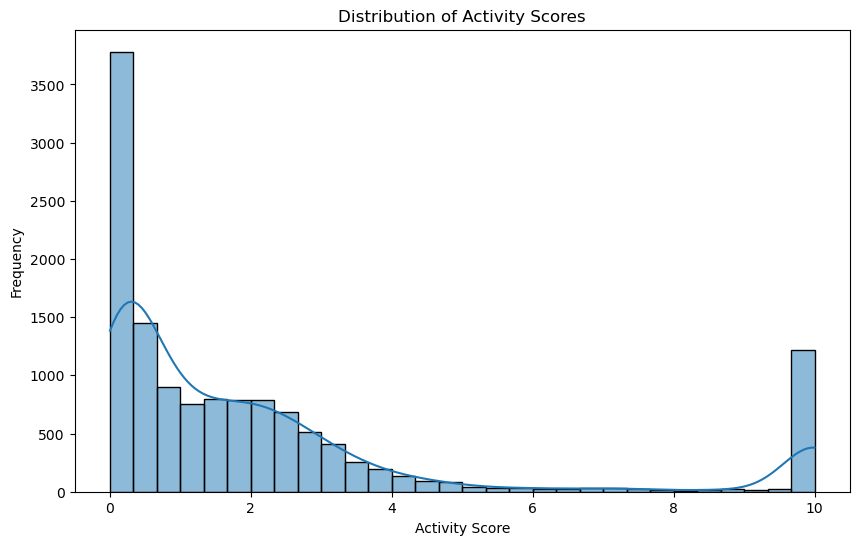

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, Add
from keras.optimizers import Adam
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.simpledialog import askinteger

# Function to load ResNet model weights adaptively
def load_resnet_model_weights(model, weights_path):
    # Load weights only if the file exists
    if os.path.exists(weights_path):
        try:
            model.load_weights(weights_path)
            print("ResNet model weights loaded successfully.")
        except ValueError as e:
            print(f"Error loading ResNet model weights: {e}")
            print("Initializing the model with random weights.")
    else:
        print("Warning: Weight file not found. The model will be initialized with random weights.")

def create_resnet_model(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(50, activation='relu')(input_layer)
    x = Dense(50, activation='relu')(x)
    residual = Dense(50, activation='relu')(input_layer)  # Residual connection
    x = Add()([x, residual])
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


def upload_csv_file():
    Tk().withdraw()  # Prevents the full GUI from popping up
    filename = askopenfilename(filetypes=[("CSV files", "*.csv")])
    return filename

def get_number_of_compounds():
    Tk().withdraw()
    number = askinteger("Input", "How many active compounds do you want to display?", minvalue=1)
    return number

# Load the new dataset for prediction
new_data_file = upload_csv_file()
new_data = pd.read_csv(new_data_file, low_memory=False)

# Preserve the 'NAME' column before preprocessing
compound_names = new_data.pop('NAME')  # Remove 'NAME' from DataFrame and store it separately

# Preprocess the new dataset
new_data = new_data.drop(columns=['Source'], errors='ignore')  # Assuming 'Source' is not needed
X_new = new_data.apply(pd.to_numeric, errors='coerce')

# Standardize the new data
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

# Determine input dimension dynamically based on the number of features
input_dim = X_new_scaled.shape[1]

# Create and load the ResNet model with dynamic input dimension
resnet_model = create_resnet_model(input_dim)
load_resnet_model_weights(resnet_model, '/home/shaban/Desktop/ChEMBL-PubChem/ResNet/1_ResNet_Model.h5')

# Make predictions only if the model has been loaded successfully
if resnet_model.weights:
    # Predict on the new dataset
    probabilities = resnet_model.predict(X_new_scaled)

    # Convert predictions to activity scores from 0 to 10
    activity_scores = probabilities * 10

    # Add the 'NAME' column back and add activity scores
    new_data['NAME'] = compound_names
    new_data['Activity_Score'] = activity_scores

    # Move 'NAME' and 'Activity_Score' to the beginning of the DataFrame
    new_data = new_data[['NAME', 'Activity_Score'] + [col for col in new_data.columns if col not in ['NAME', 'Activity_Score']]]

    # Ask user for the number of active compounds to display
    number_of_compounds = get_number_of_compounds()

    # Sort by activity score to find the most active compounds
    top_active_compounds = new_data.nlargest(number_of_compounds, 'Activity_Score')

    # Save the results to a CSV file
    new_data.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/10_Predicted_Activity_New_Drug_Library_ResNet.csv', index=False)
    print("Predictions saved successfully.")
    print("\n#######################################################################################################\n")

    # Display the top user-defined number of active compounds
    print(f"Here is the top {number_of_compounds} scored compounds:")
    for idx, row in top_active_compounds.iterrows():
        print(f"Compound: {row['NAME']}, Activity Score: {row['Activity_Score']}")
    print("\n#######################################################################################################\n")

    # Find and display compounds with an activity score of 10
    #compounds_with_score_10 = new_data[new_data['Activity_Score'] >= 10]
    #print("\nHere is the list of the compounds with a score of 10:")
    #for idx, row in compounds_with_score_10.iterrows():
     #   print(f"Compound: {row['NAME']}, Activity Score: {row['Activity_Score']}")

    # Distribution of Activity Scores
    plt.figure(figsize=(10, 6))
    sns.histplot(new_data['Activity_Score'], bins=30, kde=True)
    plt.title('Distribution of Activity Scores')
    plt.xlabel('Activity Score')
    plt.ylabel('Frequency')
    plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/11_Activity_Score_Distribution.svg', format='svg')
    plt.show()
else:
    print("Error: Failed to load ResNet model weights. Predictions cannot be made.")

## FNN

The PCA-based dimensionality reduction has identified and saved two files for top 5883 descriptors and all descriptors with their importance.
Columns 'NAME' and 'Source' dropped from the dataset.


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6763 - loss: 0.8688 - val_accuracy: 0.9180 - val_loss: 0.2721
Epoch 2/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9423 - loss: 0.1910 - val_accuracy: 0.9589 - val_loss: 0.1285
Epoch 3/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9638 - loss: 0.1155 - val_accuracy: 0.9691 - val_loss: 0.0916
Epoch 4/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9671 - loss: 0.0949 - val_accuracy: 0.9636 - val_loss: 0.0944
Epoch 5/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9747 - loss: 0.0706 - val_accuracy: 0.9737 - val_loss: 0.0767
Epoch 6/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9789 - loss: 0.0636 - val_accuracy: 0.9720 - val_loss: 0.1018
Epoch 7/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9808 - loss: 0.0568 - val_accuracy: 0.9809 - val_loss: 0.0566
Epoch 8/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9873 - loss: 0.0437 - val_accuracy: 0.

Model saved successfully.
THE TESTING & TRAINING SET ARE SAVED TO VALIDATE 
 
, NOW COMPUTING VARIOUS MATRICES
TIME TAKEN TO TRAIN THE FNN MODEL (Elapsed time): 81.76146507263184 seconds
Accuracy (FNN): 0.993560606060606


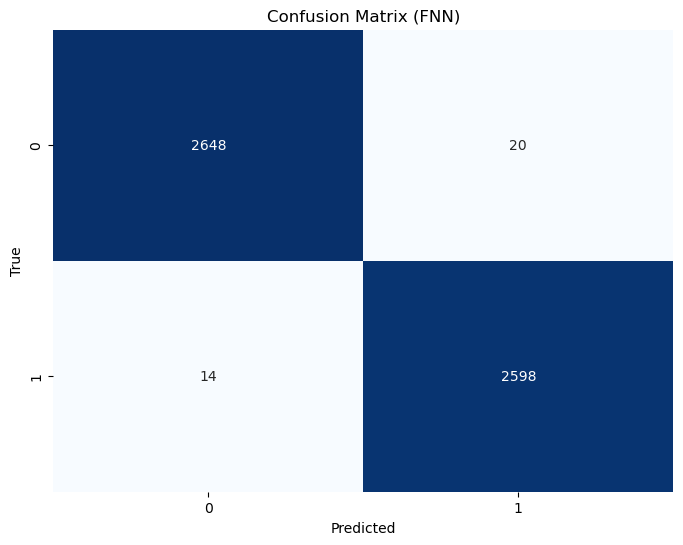

THE CONFUSION MATRIX FOR FNN IS SAVED  
 

ROC AUC (FNN): 0.9935719353187111


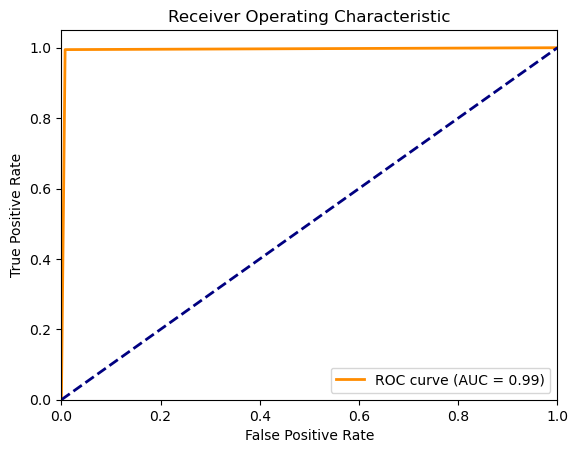

THE ROC CURVE FOR FNN IS SAVED


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mean accuracy for 5-fold CV: 0.9723438739776611, Std Deviation 5-Fold: 0.00715444996027862
Mean accuracy for 10-fold CV: 0.9720085740089417, Std Deviation 10-Fold: 0.022563224676509036
Combined Std Deviation: 0.018880848502755957


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


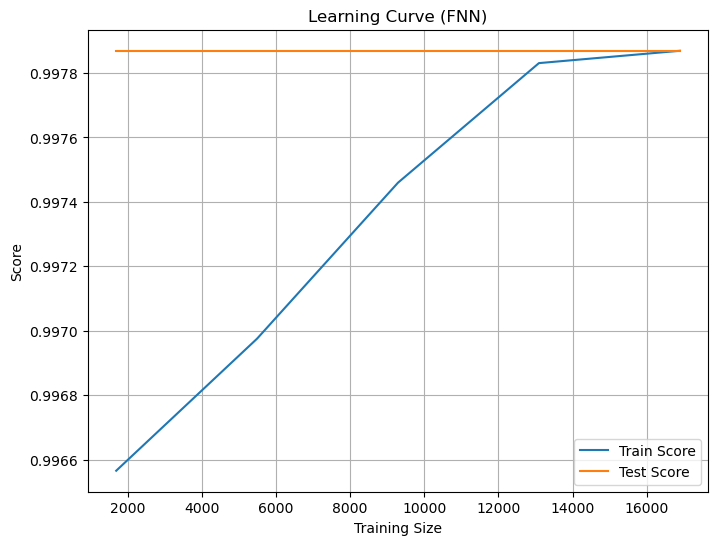

THE LEARNING CURVE FOR FNN IS SAVED
Total elapsed time for running the whole code (FNN): 679.6074187755585 seconds
THE EPOCHS OUTPUT IS SAVED


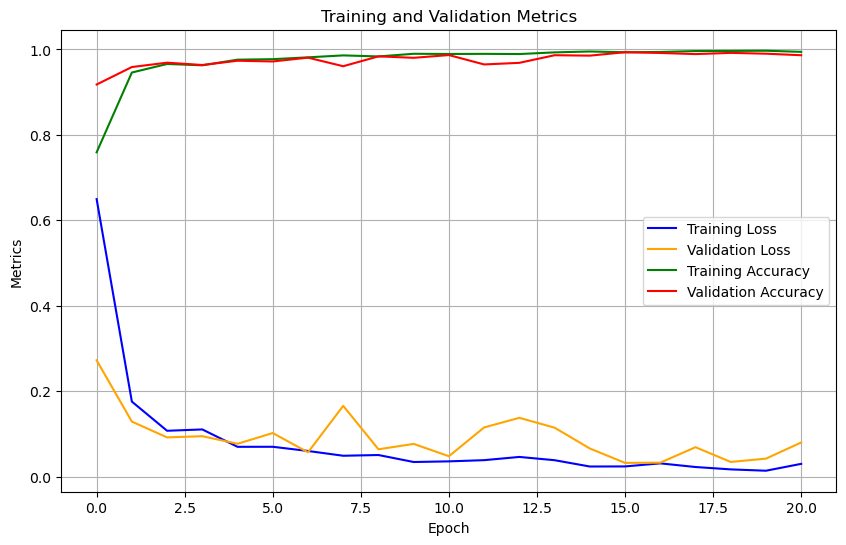

Precision (FNN): 0.9923605805958747
Recall (FNN): 0.9946401225114855
F1 Score (FNN): 0.9934990439770555

 
 
#####################################################################################
##################  ALL METRICS ARE COMPUTED AND SAVED SUCCESSFULLY  ###############
#####################################################################################
 
 

 
 
#####################################################################################
##################  HERE ARE ALL THE COMPUTED METRICS ############################### 
                          Metrics       Value
0               FNN Elapsed Time   81.761465
1                       Accuracy    0.993561
2                      Precision    0.992361
3                         Recall    0.994640
4                       F1 Score    0.993499
5                      AUC Score    0.993572
6                    Sensitivity    0.994640
7                    Specificity    0.992504
8         Mean Accuracy (5-Fold)    0.972344
9

In [ ]:
##################################################################################################################
# IMPORT THE NECESSARY LIBRARIES
##################################################################################################################
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from keras.models import Model
from keras.layers import Input, Dense, Add
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.callbacks import EarlyStopping
import os

start_time = time.time()

##################################################################################################################
# LOAD THE DATASET AND PCA TO RANK THE DESCRIPTORS
##################################################################################################################

# Load your CSV file into a data frame (assuming the descriptors are in columns)
original_data = pd.read_csv('/home/shaban/Desktop/ChEMBL-PubChem/Dataset/04_ChEMBL-PubChem_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA-MERGED.csv', low_memory=False)

# Use 'Activity' as the target variable
target_column = 'Activity'

# Replace 'na' values with NaN
original_data = original_data.replace('na', np.nan)

# Assuming the target variable is in a column with the specified name
X = original_data.drop(target_column, axis=1)
y = original_data[target_column]

# Convert each column to numeric, replacing non-convertible values with NaN
for column in X.columns:
    X[column] = pd.to_numeric(X[column], errors='coerce')

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the original_data before applying PCA
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_imputed)

# Create a PCA model with the number of components you desire
n_components = 5883  # You can change this value to the number of top descriptors you want
pca = PCA(n_components=n_components)

# Fit the PCA model on your original_data
X_pca = pca.fit_transform(X_standardized)

# Get the absolute values of the principal components
abs_components = np.abs(pca.components_)

# Create a data Frame to store feature names and their importance values
descriptor_names = X.columns  # Get the descriptor names from column headers
num_components_used = min(n_components, len(descriptor_names))  # Ensure we don't exceed the number of available descriptors

# Extract only the top components used to match the number of descriptors
abs_components_used = abs_components[:, :num_components_used]

# Create a data Frame with the selected number of components
feature_pca_df = pd.DataFrame({'Descriptor': descriptor_names[:num_components_used], 'Importance': abs_components_used.sum(axis=0)})

# Sort the descriptors by their importance
feature_pca_df = feature_pca_df.sort_values(by='Importance', ascending=False)

# Add 'Activity' feature with an importance value of 0
activity_feature = pd.DataFrame({'Descriptor': ['Activity'], 'Importance': [1]})
feature_pca_df = pd.concat([feature_pca_df, activity_feature], ignore_index=True)

# Save all the descriptors with their importance values to another CSV file
feature_pca_df.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/Dataset/06_PCA-FNN.csv', index=False)

print("The PCA-based dimensionality reduction has been saved")

# Extract feature names
selected_features = feature_pca_df['Descriptor'].tolist()

# Filter columns based on selected features and convert non-numeric values to NaN
selected_data = original_data[selected_features].apply(pd.to_numeric, errors='coerce')

# Drop columns with headers 'NAME' or 'Source'
selected_data = selected_data.drop(columns=['NAME', 'Source'], errors='ignore')
print("Columns 'NAME' and 'Source' dropped from the dataset.")

# Ensure the target column 'Activity' exists in the original dataset
if 'Activity' not in original_data.columns:
    raise KeyError("The target column 'Activity' is not present in the original dataset.")

# Define 'X' and 'y' for Train-Test Split
X = selected_data  # Assuming 'selected_data' contains all features
y = original_data['Activity']  # Assuming 'Activity' is the name of the target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reset the indices of the dataframes
X_train_scaled = pd.DataFrame(X_train_scaled).reset_index(drop=True).to_numpy()
y_train = y_train.reset_index(drop=True).to_numpy()
X_test_scaled = pd.DataFrame(X_test_scaled).reset_index(drop=True).to_numpy()
y_test = y_test.reset_index(drop=True).to_numpy()

##################################################################################################################
# FNN TRAINING
##################################################################################################################
# Define the FNN model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
start_time = time.time()
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])
end_time = time.time()

elapsed_time_fnn = end_time - start_time

# Predict on the test set
y_pred_fnn = model.predict(X_test_scaled)
y_pred_fnn = (y_pred_fnn > 0.5).astype(int)


# Save the trained model
model.save('/home/shaban/Desktop/ChEMBL-PubChem/FNN/1_FNN_Model.h5')
print("Model saved successfully.")
##################################################################################################################
# CHECK WHAT HAVE BEEN USED FOR THE TRAINING AND TESTING
##################################################################################################################
# Create DataFrames for training and testing samples
training_samples = selected_data.loc[X_train.index]
testing_samples = selected_data.loc[X_test.index]

# Save testing and Training samples to a CSV file
training_samples.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/FNN/2_FNN_RandFores_training_samples.csv', index=False)
testing_samples.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/FNN/3_FNN_RandFores_testing_samples.csv', index=False)
print("THE TESTING & TRAINING SET ARE SAVED TO VALIDATE \n \n, NOW COMPUTING VARIOUS MATRICES")

##################################################################################################################
# CHECK AND VALIDATE THE OUTPUTS
##################################################################################################################

# 1. Elapsed Time
print(f"TIME TAKEN TO TRAIN THE FNN MODEL (Elapsed time): {elapsed_time_fnn} seconds")

# 2. Calculate accuracy
accuracy_fnn = accuracy_score(y_test, y_pred_fnn)
print(f"Accuracy (FNN): {accuracy_fnn}")

# 3. Compute confusion matrix
conf_matrix_fnn = confusion_matrix(y_test, y_pred_fnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (FNN)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/FNN/4_FNN_RandForest_Con_Matrix.svg', format='svg')
plt.show()
print("THE CONFUSION MATRIX FOR FNN IS SAVED  \n \n")

# 4. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_fnn)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC (FNN): {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/FNN/5_FNN_RandForest_ROC.svg', format='svg')
plt.show()
print("THE ROC CURVE FOR FNN IS SAVED")

# 5. Perform cross-validation
skf = StratifiedKFold(n_splits=5)
cv_scores_5_fold = []
for train_index, val_index in skf.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model_fold = Sequential()
    model_fold.add(Dense(50, activation='relu', input_shape=(X_train_fold.shape[1],)))
    model_fold.add(Dense(1, activation='sigmoid'))

    model_fold.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model_fold.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    val_loss, val_accuracy = model_fold.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores_5_fold.append(val_accuracy)

cv_scores_5_fold = np.array(cv_scores_5_fold)

mean_accuracy_5_fold = np.mean(cv_scores_5_fold)
std_deviation_5_fold = np.std(cv_scores_5_fold)

# For 10-fold cross-validation, similar process is applied
skf = StratifiedKFold(n_splits=10)
cv_scores_10_fold = []
for train_index, val_index in skf.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model_fold = Sequential()
    model_fold.add(Dense(50, activation='relu', input_shape=(X_train_fold.shape[1],)))
    model_fold.add(Dense(1, activation='sigmoid'))

    model_fold.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model_fold.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    val_loss, val_accuracy = model_fold.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores_10_fold.append(val_accuracy)

cv_scores_10_fold = np.array(cv_scores_10_fold)

mean_accuracy_10_fold = np.mean(cv_scores_10_fold)
std_deviation_10_fold = np.std(cv_scores_10_fold)

# Concatenate the cross-validation scores from both 5 and 10 folds
all_cv_scores = np.concatenate([cv_scores_5_fold, cv_scores_10_fold])
# Compute the standard deviation
std_dev_all_cv = np.std(all_cv_scores)

print(f"Mean accuracy for 5-fold CV: {mean_accuracy_5_fold}, Std Deviation 5-Fold: {std_deviation_5_fold}")
print(f"Mean accuracy for 10-fold CV: {mean_accuracy_10_fold}, Std Deviation 10-Fold: {std_deviation_10_fold}")
print(f"Combined Std Deviation: {std_dev_all_cv}")

# 6. Plot learning curve for FNN
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # No need to fit the model separately, as it's already trained in the main script
        return self

    def predict(self, X):
        # Perform predictions using the Keras model
        return (self.model.predict(X) > 0.5).astype(int)

    def score(self, X, y):
        # Compute accuracy score using the Keras model
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

# Create a wrapper instance with the trained Keras model
keras_wrapper = KerasClassifierWrapper(model)

# Now, you can use this wrapper with the learning_curve function
train_sizes_fnn, train_scores_fnn, test_scores_fnn = learning_curve(keras_wrapper, X_train_scaled, y_train, cv=5)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_fnn, train_scores_fnn.mean(axis=1), label='Train Score')
plt.plot(train_sizes_fnn, test_scores_fnn.mean(axis=1), label='Test Score')
plt.title('Learning Curve (FNN)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/FNN/6_FNN_RandForest_LearningCurve.svg', format='svg')
plt.show()
print("THE LEARNING CURVE FOR FNN IS SAVED")

# 7. Compute sensitivity and specificity for FNN
tn_fnn, fp_fnn, fn_fnn, tp_fnn = conf_matrix_fnn.ravel()
sensitivity_fnn = tp_fnn / (tp_fnn + fn_fnn)
specificity_fnn = tn_fnn / (tn_fnn + fp_fnn)

# 8. Compute the total elapsed time for FNN
total_elapsed_time_fnn = time.time() - start_time
print(f"Total elapsed time for running the whole code (FNN): {total_elapsed_time_fnn} seconds")

# 9. Save epoch outputs to CSV and Plot it
epochs_df = pd.DataFrame(history.history)
epochs_df.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/FNN/7_FNN_RandomForest_Epoch_Outputs.csv', index=False)
print("THE EPOCHS OUTPUT IS SAVED")

plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/FNN/8_FNN_RandomForest_Epochs_.svg', format='svg')
plt.show()

# 10. Compute precision, recall, and F1 score for FNN
precision_fnn = precision_score(y_test, y_pred_fnn)
recall_fnn = recall_score(y_test, y_pred_fnn)
f1_fnn = f1_score(y_test, y_pred_fnn)

print(f"Precision (FNN): {precision_fnn}")
print(f"Recall (FNN): {recall_fnn}")
print(f"F1 Score (FNN): {f1_fnn}")

############################################################################################################
# SAVING THE OUTPUTS IN CSV
##################################################################################################################
# Check if the output file exists
output_file = '/home/shaban/Desktop/ChEMBL-PubChem/FNN/9_ALL_FNN_Metrics.csv'
file_exists = os.path.isfile(output_file)

# Create DataFrame for all metrics
metrics_df = pd.DataFrame({
    'Metrics': ['FNN Elapsed Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score', 'Sensitivity', 'Specificity', 'Mean Accuracy (5-Fold)', 'Standard Deviation (5-Fold)', 'Mean Accuracy (10-Fold)', 'Standard Deviation (10-Fold)', 'St Dv of 5-Fold & 10-Fold', 'Total Elapsed Time'],
    'Value': [elapsed_time_fnn, accuracy_fnn, precision_fnn, recall_fnn, f1_fnn, roc_auc, sensitivity_fnn, specificity_fnn, mean_accuracy_5_fold, std_deviation_5_fold, mean_accuracy_10_fold, std_deviation_10_fold, std_dev_all_cv, total_elapsed_time_fnn]
})

metrics_df.to_csv(output_file, index=False)

print("\n \n \n#####################################################################################")
print('##################  ALL METRICS ARE COMPUTED AND SAVED SUCCESSFULLY  ###############')
print("#####################################################################################\n \n ")
print("\n \n \n#####################################################################################")
print('##################  HERE ARE ALL THE COMPUTED METRICS ############################### \n', metrics_df)
print("\n #####################################################################################\n \n \n ")

/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


FNN model weights loaded successfully.
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predictions saved successfully.
Here is the top 5 scored compounds:
Compound: Active_CHEMBL618678_CHEMBL1202597, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202602, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1204204, Activity Score: 10.0
Compound: Active_CHEMBL619601_CHEMBL343641, Activity Score: 10.0
Compound: Active_CHEMBL688763_CHEMBL540565, Activity Score: 10.0

Here is the list of the compounds with 10 scores which you probably use with docking to screen the best:


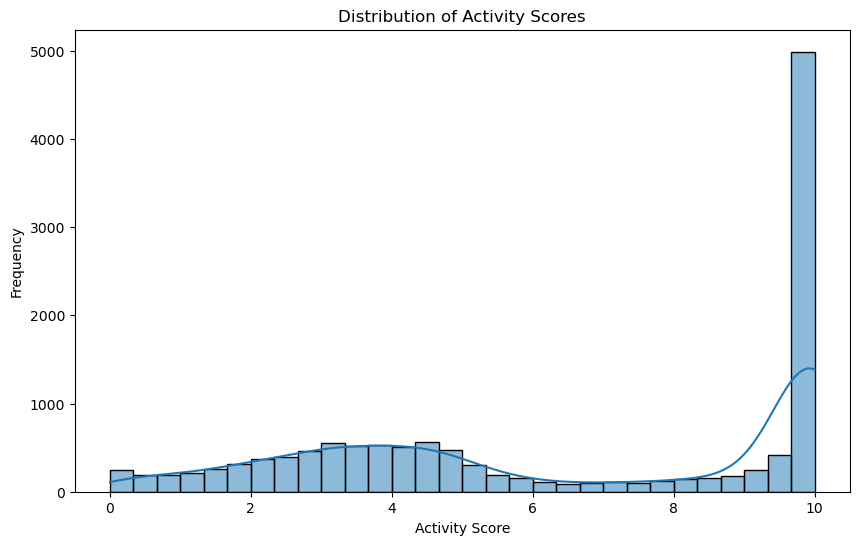

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.simpledialog import askinteger
import seaborn as sns

# Function to load FNN model weights
def load_FNN_model_weights(model, weights_path):
    model.load_weights(weights_path)
    print("FNN model weights loaded successfully.")

# Define the FNN model architecture (matching the one used during training)
def create_FNN_model(input_dim):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def upload_csv_file():
    Tk().withdraw()  # Prevents the full GUI from popping up
    filename = askopenfilename(filetypes=[("CSV files", "*.csv")])
    return filename

def get_number_of_compounds():
    Tk().withdraw()
    number = askinteger("Input", "How many active compounds do you want to display?", minvalue=1)
    return number

# Load the new dataset for prediction
new_data_file = upload_csv_file()
new_data = pd.read_csv(new_data_file, low_memory=False)

# Preserve the 'NAME' column before preprocessing
compound_names = new_data['NAME']

# Preprocess the new dataset
new_data = new_data.drop(columns=['NAME', 'Source'], errors='ignore')
X_new = new_data.apply(pd.to_numeric, errors='coerce')

# Standardize the new data
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

# Create and load the FNN model
input_dim = X_new_scaled.shape[1]
FNN_model = create_FNN_model(input_dim)
load_FNN_model_weights(FNN_model, '/home/shaban/Desktop/ChEMBL-PubChem/FNN/1_FNN_Model.h5')

# Make predictions
probabilities = FNN_model.predict(X_new_scaled)

# Convert predictions to activity scores from 0 to 10
activity_scores = probabilities * 10

# Add the 'NAME' column back and add activity scores
new_data['NAME'] = compound_names
new_data['Activity_Score'] = activity_scores

# Move 'NAME' and 'Activity_Score' to the beginning of the DataFrame
new_data = new_data[['NAME', 'Activity_Score'] + [col for col in new_data.columns if col not in ['NAME', 'Activity_Score']]]

# Ask user for the number of active compounds to display
number_of_compounds = get_number_of_compounds()

# Sort by activity score to find the most active compounds
top_active_compounds = new_data.nlargest(number_of_compounds, 'Activity_Score')

# Save the results to a CSV file
new_data.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/FNN/10_Predicted_Activity_New_Drug_Library_FNN.csv', index=False)
print("Predictions saved successfully.")

# Display the top user-defined number of active compounds
print(f"Here is the top {number_of_compounds} scored compounds:")
for idx, row in top_active_compounds.iterrows():
    print(f"Compound: {row['NAME']}, Activity Score: {row['Activity_Score']}")

# Find and display compounds with an activity score of 10
compounds_with_score_10 = new_data[new_data['Activity_Score'] >= 10]
print("\nHere is the list of the compounds with 10 scores which you probably use with docking to screen the best:")
#for idx, row in compounds_with_score_10.iterrows():
#    print(f"Compound: {row['NAME']}, Activity Score: {row['Activity_Score']}")

# Distribution of Activity Scores
plt.figure(figsize=(10, 6))
sns.histplot(new_data['Activity_Score'], bins=30, kde=True)
plt.title('Distribution of Activity Scores')
plt.xlabel('Activity Score')
plt.ylabel('Frequency')
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/FNN/11_Activity_Score_Distribution.svg', format='svg')
plt.show()

## RNN

PCA dimensity Reduction has been saved


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 193s 280ms/step - accuracy: 0.7846 - loss: 0.6990 - val_accuracy: 1.0000 - val_loss: 0.2598
Epoch 2/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 181s 274ms/step - accuracy: 0.9568 - loss: 0.3540 - val_accuracy: 1.0000 - val_loss: 0.2031
Epoch 3/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 180s 273ms/step - accuracy: 0.9839 - loss: 0.2659 - val_accuracy: 1.0000 - val_loss: 0.1621
Epoch 4/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 178s 270ms/step - accuracy: 0.9893 - loss: 0.2097 - val_accuracy: 1.0000 - val_loss: 0.1285
Epoch 5/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 178s 269ms/step - accuracy: 0.9925 - loss: 0.1636 - val_accuracy: 1.0000 - val_loss: 0.0991
Epoch 6/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 177s 269ms/step - accuracy: 0.9952 - loss: 0.1251 - val_accuracy: 1.0000 - val_loss: 0.0732
Epoch 7/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 179s 271ms/step - accuracy: 0.9976 - loss: 0.0914 - val_accuracy: 1.0000 - val_loss: 0.0522
Epoch 8/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 178s 270ms/step - accuracy: 

Model saved successfully.
THE TESTING & TRAINING SET ARE SAVED TO VALIDATE 
 
 NOW COMPUTING VARIOUS MATRICES
TIME TAKEN TO TRAIN THE RNN MODEL (Elapsed time): 18253.97317457199 seconds
Accuracy (RNN): 1.0


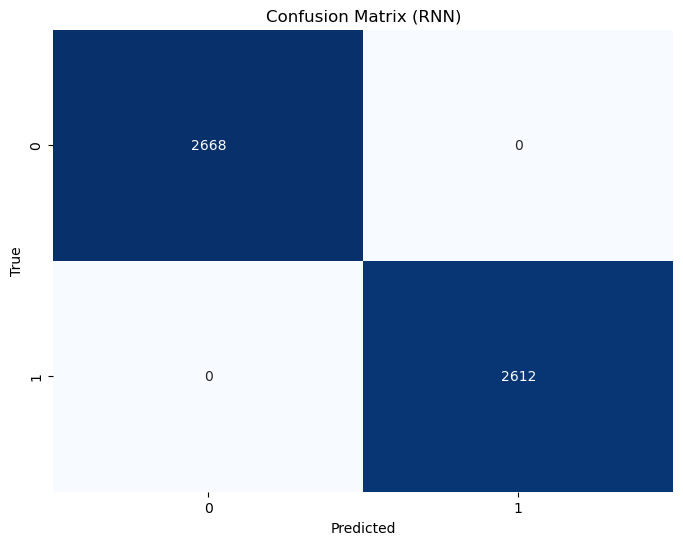

THE CONFUSION MATRIX FOR RNN IS SAVED  
 

ROC AUC (RNN): 1.0


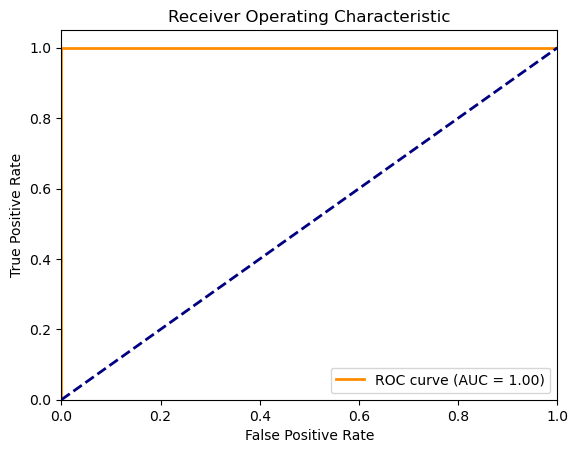

THE ROC CURVE FOR RNN IS SAVED


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Mean accuracy for 5-fold CV: 1.0, Std Deviation 5-Fold: 0.0
Mean accuracy for 10-fold CV: 1.0, Std Deviation 10-Fold: 0.0
Combined Std Deviation: 0.0


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
291/291 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step


/home/shaban/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step
528/528 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step


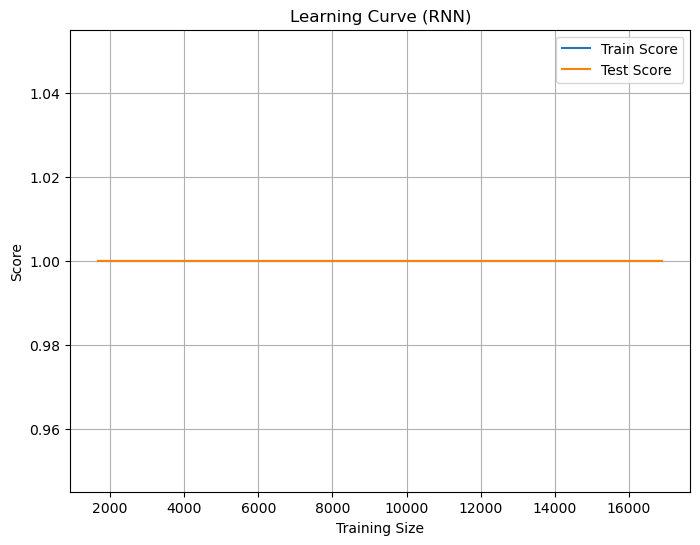

THE LEARNING CURVE FOR RNN IS SAVED
Total elapsed time for running the whole code (RNN): 55214.30985569954 seconds
THE EPOCHS OUTPUT IS SAVED


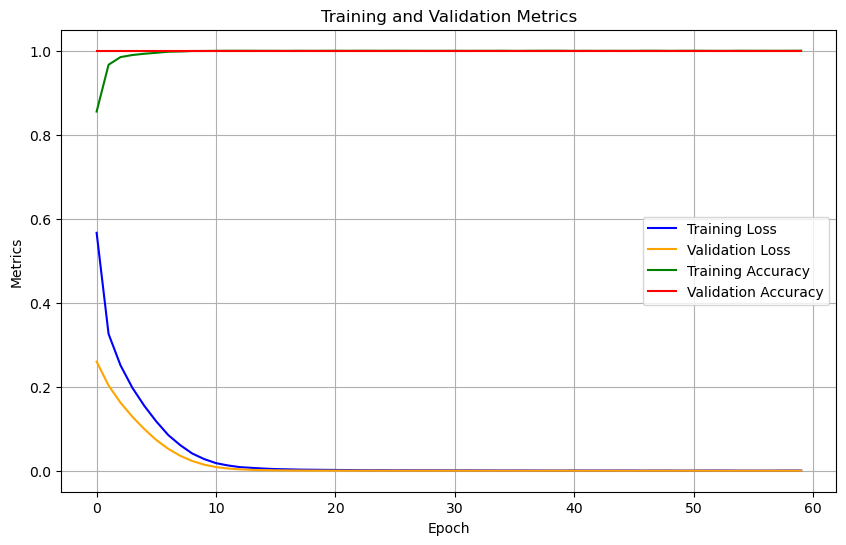

Precision (RNN): 1.0
Recall (RNN): 1.0
F1 Score (RNN): 1.0

 
 
#####################################################################################
##################  ALL METRICS ARE COMPUTED AND SAVED SUCCESSFULLY  ###############
#####################################################################################
 
 

 
 
#####################################################################################
##################  HERE ARE ALL THE COMPUTED METRICS ############################### 
                          Metrics         Value
0               RNN Elapsed Time  18253.973175
1                       Accuracy      1.000000
2                      Precision      1.000000
3                         Recall      1.000000
4                       F1 Score      1.000000
5                      AUC Score      1.000000
6                    Sensitivity      1.000000
7                    Specificity      1.000000
8         Mean Accuracy (5-Fold)      1.000000
9    Standard Deviation (5

In [ ]:
##################################################################################################################
# IMPORT THE NECESSARY LIBRARIES
##################################################################################################################
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import SimpleRNN, Dense, Input, Add
from keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
import os
from keras.regularizers import l2
from keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization


start_time = time.time()

##################################################################################################################
# LOAD THE DATASET AND PCA TO RANK THE DESCRIPTORS
##################################################################################################################
# Load the dataset
original_data = pd.read_csv('/home/shaban/Desktop/ChEMBL-PubChem/Dataset/04_ChEMBL-PubChem_Active-Inactive_Activity_Desciptors_QikProp_MACCS-FP_UNIQUE_MEAN_ROUND_FINAL_EQUAL-DATA-MERGED.csv', low_memory=False)

target_column = 'Activity'
original_data = original_data.replace('na', np.nan)
X = original_data.drop(target_column, axis=1)
y = original_data[target_column]

for column in X.columns:
    X[column] = pd.to_numeric(X[column], errors='coerce')

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_imputed)

n_components = 5883
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)
abs_components = np.abs(pca.components_)

descriptor_names = X.columns
num_components_used = min(n_components, len(descriptor_names))
abs_components_used = abs_components[:, :num_components_used]

feature_pca_df = pd.DataFrame({'Descriptor': descriptor_names[:num_components_used], 'Importance': abs_components_used.sum(axis=0)})
feature_pca_df = feature_pca_df.sort_values(by='Importance', ascending=False)
activity_feature = pd.DataFrame({'Descriptor': ['Activity'], 'Importance': [1]})
feature_pca_df = pd.concat([feature_pca_df, activity_feature], ignore_index=True)
feature_pca_df.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/Dataset/06_PCA-RNN.csv', index=False)
print("PCA dimensity Reduction has been saved")
selected_features = feature_pca_df['Descriptor'].tolist()
selected_data = original_data[selected_features].apply(pd.to_numeric, errors='coerce')
selected_data = selected_data.drop(columns=['NAME', 'Source'], errors='ignore')

X = selected_data
y = original_data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for RNN
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

##################################################################################################################
# RNN TRAINING
##################################################################################################################
# Define the RNN model
model = Sequential()
model.add(SimpleRNN(32, activation='relu', input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])
end_time = time.time()

elapsed_time_rnn = end_time - start_time

y_pred_rnn = model.predict(X_test_scaled)
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)


model.save('/home/shaban/Desktop/ChEMBL-PubChem/RNN/1_RNN_Model.h5')
print("Model saved successfully.")

##################################################################################################################
#CHECK WHAT HAVE BEEN USED FOR THE TRAINING AND TESTING
##################################################################################################################
# Create DataFrames for training and testing samples
training_samples = selected_data.loc[X_train.index]
testing_samples = selected_data.loc[X_test.index]

# Save testing and Training samples to a CSV file
training_samples.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/RNN/2_RNN_training_samples.csv', index=False)
testing_samples.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/RNN/3_RNN_testing_samples.csv', index=False)
print("THE TESTING & TRAINING SET ARE SAVED TO VALIDATE \n \n NOW COMPUTING VARIOUS MATRICES")

# Display the training samples
#print("Training set samples:")
#print(training_samples)
#print("Training set indices:")
#print(X_train.index)

# Display the testing samples
#print("\nTesting set samples:")
#print(testing_samples)
#print("\nTesting set indices:")
#print(X_test.index)

##################################################################################################################
#CHECK AND VALIDATE THE OUTPUTS
##################################################################################################################

# 1. Elapsed Time
print(f"TIME TAKEN TO TRAIN THE RNN MODEL (Elapsed time): {elapsed_time_rnn} seconds")

# 2. Calculate accuracy
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
print(f"Accuracy (RNN): {accuracy_rnn}")

# 3. Compute confusion matrix
conf_matrix_rnn = confusion_matrix(y_test, y_pred_rnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (RNN)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/RNN/4_RNN_Con_Matrix.svg', format='svg')
plt.show()
print("THE CONFUSION MATRIX FOR RNN IS SAVED  \n \n")


# 3. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_rnn)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC (RNN): {roc_auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/RNN/5_RNN_ROC.svg', format='svg')
plt.show()
print("THE ROC CURVE FOR RNN IS SAVED")


# 5. Perform cross-validation
# Ensure y_train is a numpy array
y_train = np.array(y_train)

skf = StratifiedKFold(n_splits=5)
cv_scores_5_fold = []
for train_index, val_index in skf.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    X_train_fold_rnn = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_val_fold_rnn = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))

    model_fold = Sequential()
    model_fold.add(SimpleRNN(50, input_shape=(X_train_fold.shape[1], 1)))
    model_fold.add(Dense(1, activation='sigmoid'))

    model_fold.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model_fold.fit(X_train_fold_rnn, y_train_fold, epochs=20, batch_size=32, verbose=0)

    val_loss, val_accuracy = model_fold.evaluate(X_val_fold_rnn, y_val_fold, verbose=0)
    cv_scores_5_fold.append(val_accuracy)

cv_scores_5_fold = np.array(cv_scores_5_fold)

mean_accuracy_5_fold = np.mean(cv_scores_5_fold)
std_deviation_5_fold = np.std(cv_scores_5_fold)

# For 10-fold cross-validation, similar process is applied
skf = StratifiedKFold(n_splits=10)
cv_scores_10_fold = []
for train_index, val_index in skf.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    X_train_fold_rnn = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
    X_val_fold_rnn = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))

    model_fold = Sequential()
    model_fold.add(SimpleRNN(50, input_shape=(X_train_fold.shape[1], 1)))
    model_fold.add(Dense(1, activation='sigmoid'))

    model_fold.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model_fold.fit(X_train_fold_rnn, y_train_fold, epochs=10, batch_size=32, verbose=0)

    val_loss, val_accuracy = model_fold.evaluate(X_val_fold_rnn, y_val_fold, verbose=0)
    cv_scores_10_fold.append(val_accuracy)

cv_scores_10_fold = np.array(cv_scores_10_fold)

mean_accuracy_10_fold = np.mean(cv_scores_10_fold)
std_deviation_10_fold = np.std(cv_scores_10_fold)

# Concatenate the cross-validation scores from both 5 and 10 folds
all_cv_scores = np.concatenate([cv_scores_5_fold, cv_scores_10_fold])
# Compute the standard deviation
std_dev_all_cv = np.std(all_cv_scores)

print(f"Mean accuracy for 5-fold CV: {mean_accuracy_5_fold}, Std Deviation 5-Fold: {std_deviation_5_fold}")
print(f"Mean accuracy for 10-fold CV: {mean_accuracy_10_fold}, Std Deviation 10-Fold: {std_deviation_10_fold}")
print(f"Combined Std Deviation: {std_dev_all_cv}")


# 6. Plot learning curve for RNN
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # No need to fit the model separately, as it's already trained in the main script
        return self

    def predict(self, X):
        # Perform predictions using the Keras model
        return (self.model.predict(X) > 0.5).astype(int)

    def score(self, X, y):
        # Compute accuracy score using the Keras model
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

# Create a wrapper instance with the trained Keras model
keras_wrapper = KerasClassifierWrapper(model)

# Now, you can use this wrapper with the learning_curve function
train_sizes_rnn, train_scores_rnn, test_scores_rnn = learning_curve(keras_wrapper, X_train_rnn, y_train, cv=5)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_rnn, train_scores_rnn.mean(axis=1), label='Train Score')
plt.plot(train_sizes_rnn, test_scores_rnn.mean(axis=1), label='Test Score')
plt.title('Learning Curve (RNN)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/RNN/6_RNN_LearningCurve.svg', format='svg')
plt.show()
print("THE LEARNING CURVE FOR RNN IS SAVED")

# 7. Compute sensitivity and specificity for RNN
tn_rnn, fp_rnn, fn_rnn, tp_rnn = conf_matrix_rnn.ravel()
sensitivity_rnn = tp_rnn / (tp_rnn + fn_rnn)
specificity_rnn = tn_rnn / (tn_rnn + fp_rnn)

# 8. Compute the total elapsed time for RNN
total_elapsed_time_rnn = time.time() - start_time
print(f"Total elapsed time for running the whole code (RNN): {total_elapsed_time_rnn} seconds")

# 9. Save epoch outputs to CSV and Plot it
epochs_df = pd.DataFrame(history.history)
epochs_df.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/RNN/7_RNN_Epoch_Outputs.csv', index=False)
print("THE EPOCHS OUTPUT IS SAVED")

plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/RNN/8_RNN_Epochs_.svg', format='svg')
plt.show()


# 10. Compute precision, recall, and F1 score for RNN
precision_rnn = precision_score(y_test, y_pred_rnn)
recall_rnn = recall_score(y_test, y_pred_rnn)
f1_rnn = f1_score(y_test, y_pred_rnn)

print(f"Precision (RNN): {precision_rnn}")
print(f"Recall (RNN): {recall_rnn}")
print(f"F1 Score (RNN): {f1_rnn}")


############################################################################################################
# SAVING THE OUTPUTS IN CSV
##################################################################################################################
# Check if the output file exists
output_file = '/home/shaban/Desktop/ChEMBL-PubChem/RNN/9_ALL_RNN_Metrics.csv'
file_exists = os.path.isfile(output_file)

# Create DataFrame for all metrics
metrics_df = pd.DataFrame({
    'Metrics': ['RNN Elapsed Time', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score', 'Sensitivity', 'Specificity', 'Mean Accuracy (5-Fold)', 'Standard Deviation (5-Fold)', 'Mean Accuracy (10-Fold)', 'Standard Deviation (10-Fold)', 'St Dv of 5-Fold & 10-Fold', 'Total Elapsed Time'],
    'Value': [elapsed_time_rnn, accuracy_rnn, precision_rnn, recall_rnn, f1_rnn, roc_auc, sensitivity_rnn, specificity_rnn, mean_accuracy_5_fold, std_deviation_5_fold, mean_accuracy_10_fold, std_deviation_10_fold, std_dev_all_cv, total_elapsed_time_rnn]
})

# Append or create the CSV file
if file_exists:
    with open(output_file, 'a') as f:
        for index, row in metrics_df.iterrows():
            if index == 0:
                f.write(f"\t{row['Metrics']}\t{row['Value']}\n")
            else:
                f.write(f"\t{row['Metrics']}\t{row['Value']}\n")
else:
    metrics_df.to_csv(output_file, index=False)

print("\n \n \n#####################################################################################")
print('##################  ALL METRICS ARE COMPUTED AND SAVED SUCCESSFULLY  ###############')
print("#####################################################################################\n \n ")
print("\n \n \n#####################################################################################")
print('##################  HERE ARE ALL THE COMPUTED METRICS ############################### \n', metrics_df)
print("\n #####################################################################################\n \n \n ")

RNN model loaded successfully.
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step
Predictions saved successfully.
Here is the top 5 scored compounds:
Compound: Active_CHEMBL618678_CHEMBL1202596, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202597, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202602, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1204204, Activity Score: 10.0
Compound: Active_CHEMBL619473_CHEMBL3545252, Activity Score: 10.0

Here is the list of the compounds with 10 scores which you probably use with docking to screen the best:
Compound: Active_CHEMBL618678_CHEMBL1202596, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202597, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202602, Activity Score: 10.0
Compound: Active_CHEMBL618678_CHEMBL1204204, Activity Score: 10.0
Compound: Active_CHEMBL619473_CHEMBL3545252, Activity Score: 10.0
Compound: Active_CHEMBL622718_CHEMBL537929, Activity Score: 10.0
Compound: Active_CHEMBL6887

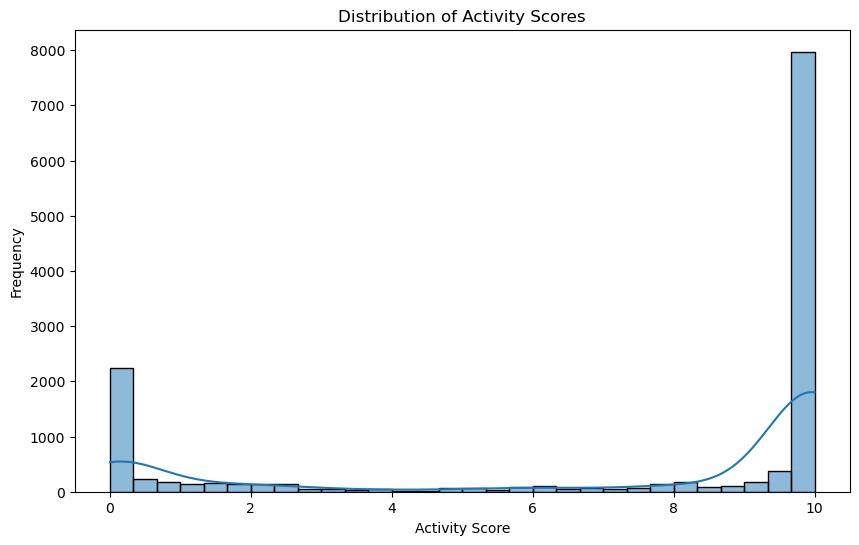

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.simpledialog import askinteger
import seaborn as sns

def upload_csv_file():
    Tk().withdraw()
    filename = askopenfilename(filetypes=[("CSV files", "*.csv")])
    return filename

def get_number_of_compounds():
    Tk().withdraw()
    number = askinteger("Input", "How many active compounds do you want to display?", minvalue=1)
    return number

# Load the new dataset for prediction
new_data_file = upload_csv_file()
new_data = pd.read_csv(new_data_file, low_memory=False)

compound_names = new_data['NAME']

new_data = new_data.drop(columns=['NAME', 'Source'], errors='ignore')
X_new = new_data.apply(pd.to_numeric, errors='coerce')

scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

RNN_model = load_model('/home/shaban/Desktop/ChEMBL-PubChem/RNN/1_RNN_Model.h5')
print("RNN model loaded successfully.")

probabilities = RNN_model.predict(X_new_scaled)

activity_scores = probabilities * 10

new_data['NAME'] = compound_names
new_data['Activity_Score'] = activity_scores

new_data = new_data[['NAME', 'Activity_Score'] + [col for col in new_data.columns if col not in ['NAME', 'Activity_Score']]]

number_of_compounds = get_number_of_compounds()

top_active_compounds = new_data.nlargest(number_of_compounds, 'Activity_Score')

new_data.to_csv('/home/shaban/Desktop/ChEMBL-PubChem/RNN/10_Predicted_Activity_New_Drug_Library_RNN.csv', index=False)
print("Predictions saved successfully.")

print(f"Here is the top {number_of_compounds} scored compounds:")
for idx, row in top_active_compounds.iterrows():
    print(f"Compound: {row['NAME']}, Activity Score: {row['Activity_Score']}")

compounds_with_score_10 = new_data[new_data['Activity_Score'] >= 10]
print("\nHere is the list of the compounds with 10 scores which you probably use with docking to screen the best:")
for idx, row in compounds_with_score_10.iterrows():
    print(f"Compound: {row['NAME']}, Activity Score: {row['Activity_Score']}")

plt.figure(figsize=(10, 6))
sns.histplot(new_data['Activity_Score'], bins=30, kde=True)
plt.title('Distribution of Activity Scores')
plt.xlabel('Activity Score')
plt.ylabel('Frequency')
plt.savefig('/home/shaban/Desktop/ChEMBL-PubChem/RNN/11_Activity_Score_Distribution.svg', format='svg')
plt.show()

#--------------------------------------------------------------------------------------------------

# Ensemble Learning (Average, Majority Voting, Stacking)
from the H5 of ResNet, FNN, RNN

413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Top 5 compounds by ResNet_Activity:
Compound: Active_CHEMBL618678_CHEMBL1202596, ResNet_Activity: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202597, ResNet_Activity: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202602, ResNet_Activity: 10.0
Compound: Active_CHEMBL618678_CHEMBL1204204, ResNet_Activity: 10.0
Compound: Active_CHEMBL688763_CHEMBL540565, ResNet_Activity: 10.0

Top 5 compounds by RNN_Activity:
Compound: Active_CHEMBL618678_CHEMBL1202596, RNN_Activity: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202597, RNN_Activity: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202602, RNN_Activity: 10.0
Compound: Active_CHEMBL618678_CHEMBL1204204, RNN_Activity: 10.0
Compound: Active_CHEMBL619473_CHEMBL3545252, RNN_Activity: 10.0

Top 5 compounds by FNN_Activity:
Compound: Active_CHEMBL618678_CHEMBL1202597, FNN_Activity: 10.0
Compound: Active_CHEMBL618678_CHEMBL1202602, FNN_Act

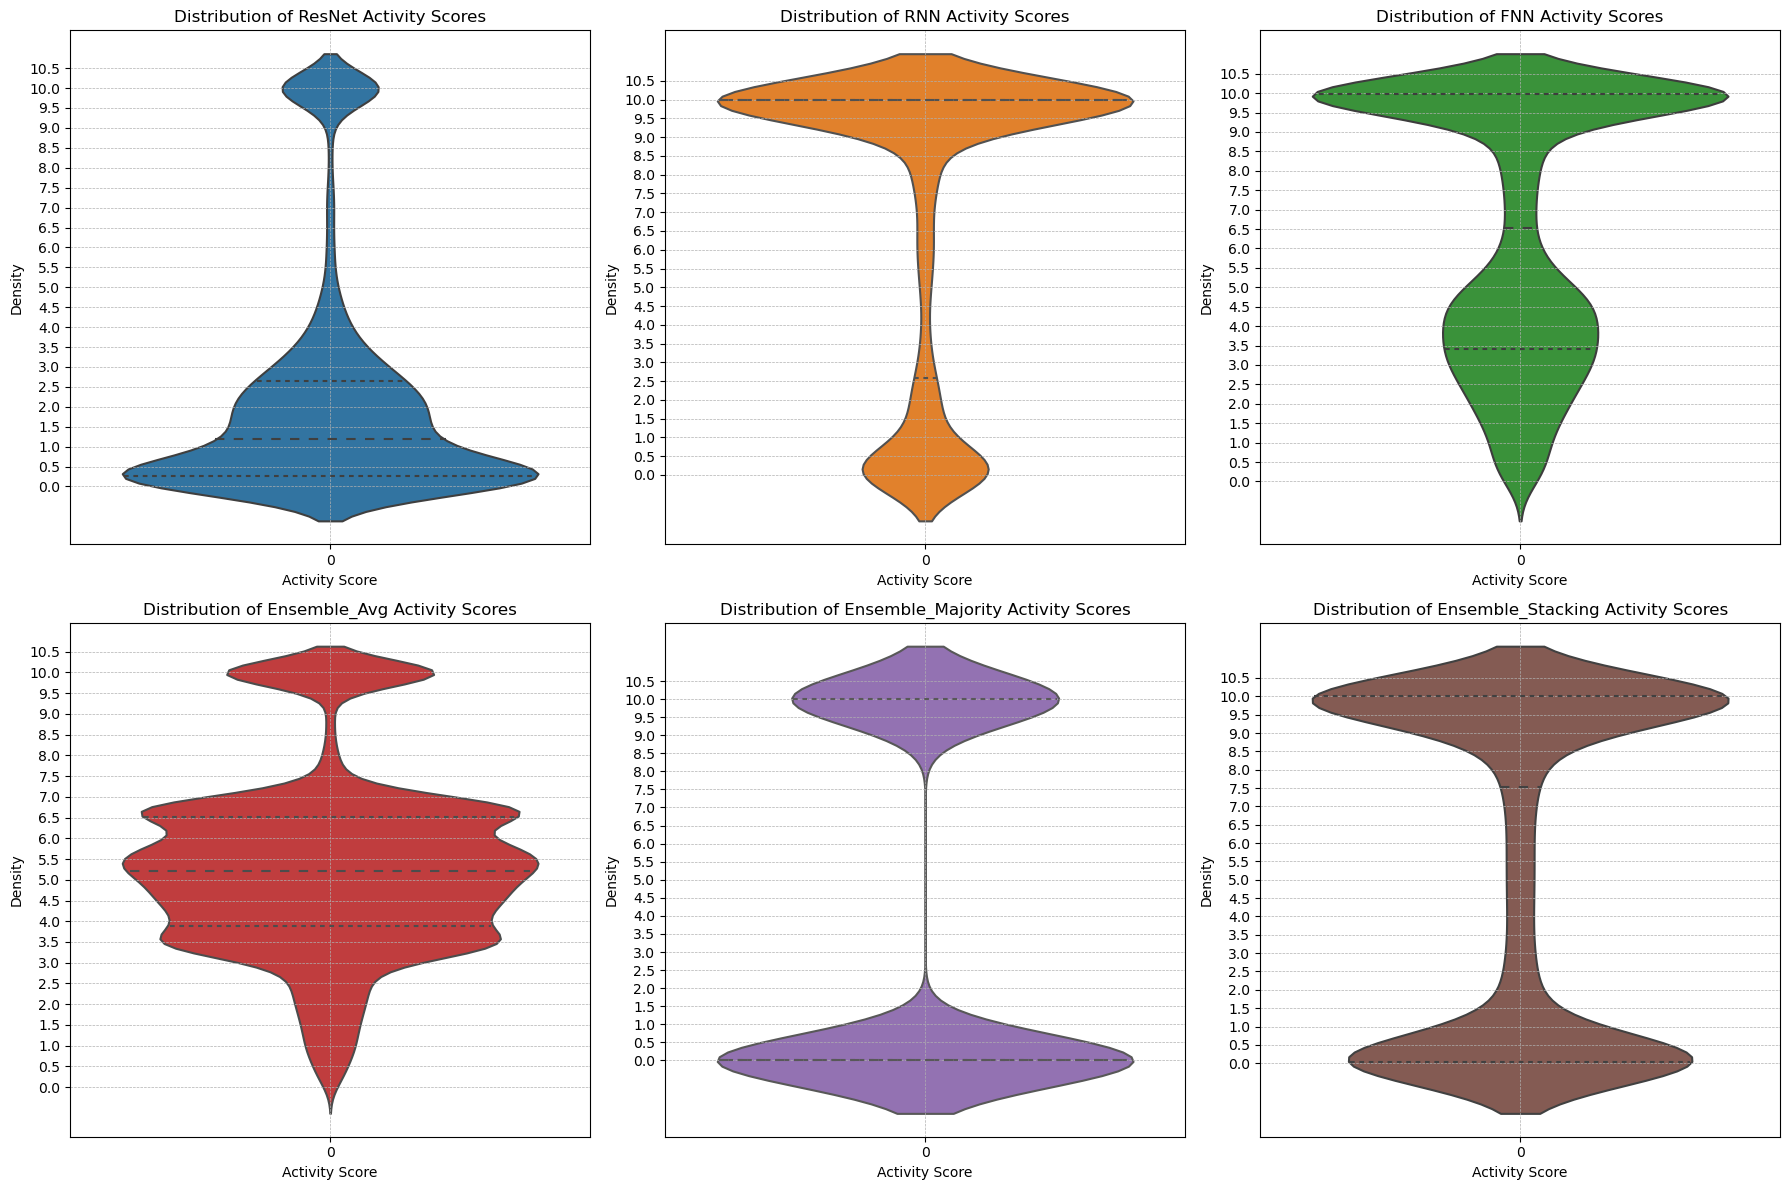

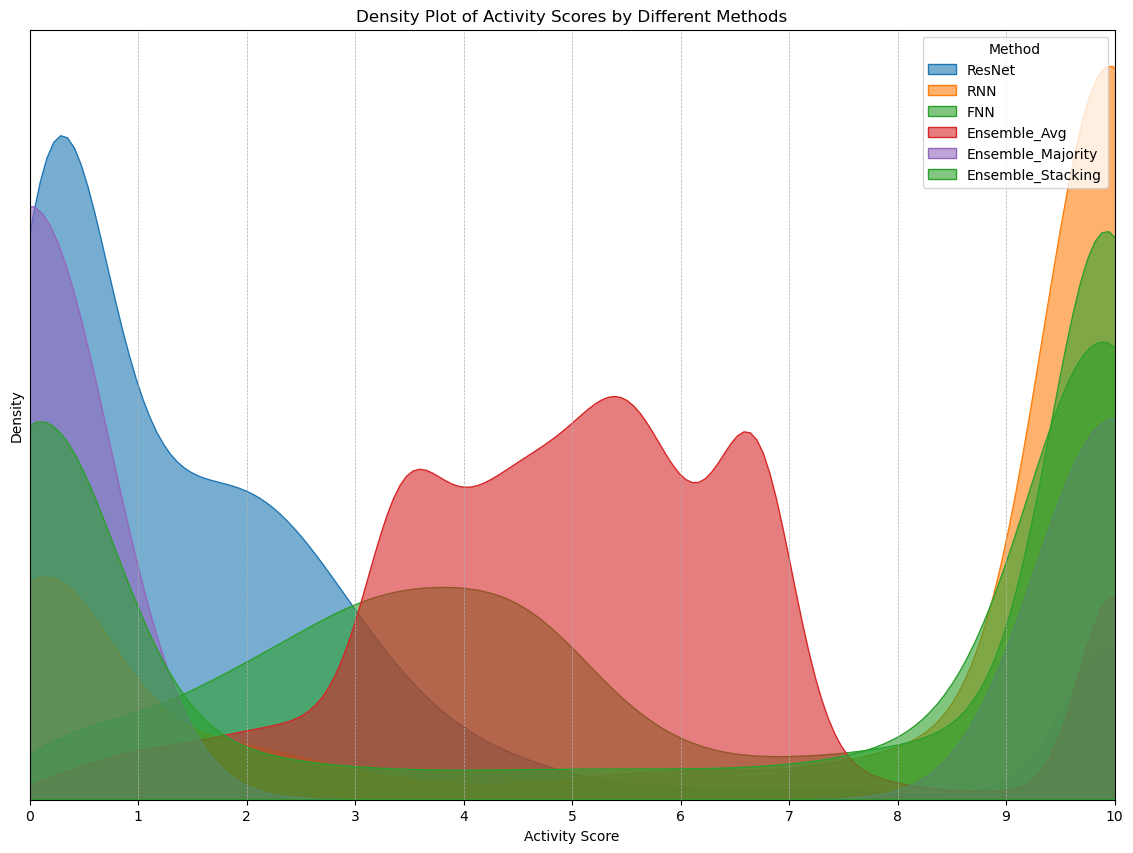

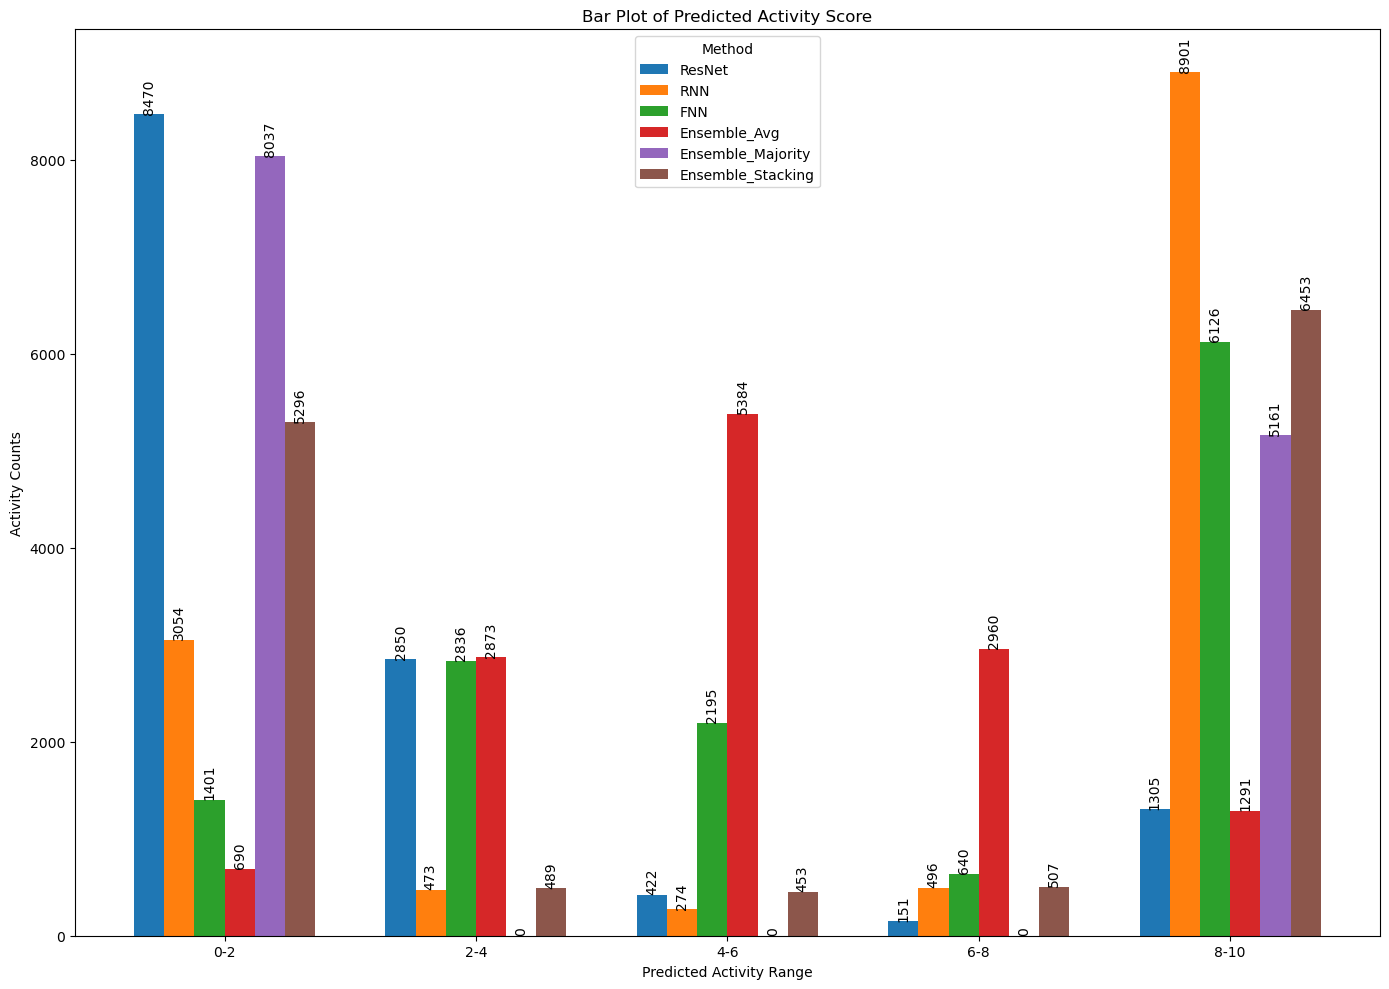

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.optimizers import Adam
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.simpledialog import askinteger
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode

# Function to upload CSV file
def upload_csv_file():
    Tk().withdraw()
    filename = askopenfilename(filetypes=[("CSV files", "*.csv")])
    return filename

# Function to get the number of compounds to display
def get_number_of_compounds():
    Tk().withdraw()
    number = askinteger("Input", "How many active compounds do you want to display?", minvalue=1)
    return number

# Function to load and preprocess new dataset
def preprocess_new_data(file_path):
    new_data = pd.read_csv(file_path, low_memory=False)
    compound_names = new_data['NAME']
    new_data = new_data.drop(columns=['NAME', 'Source'], errors='ignore')
    X_new = new_data.apply(pd.to_numeric, errors='coerce')
    scaler = StandardScaler()
    X_new_scaled = scaler.fit_transform(X_new)
    return X_new_scaled, compound_names

# Function to load and compile models
def load_and_compile_models():
    resnet_model = load_model('/home/shaban/Desktop/ChEMBL-PubChem/ResNet/1_ResNet_Model.h5', compile=False)
    rnn_model = load_model('/home/shaban/Desktop/ChEMBL-PubChem/RNN/1_RNN_Model.h5', compile=False)
    fnn_model = load_model('/home/shaban/Desktop/ChEMBL-PubChem/FNN/1_FNN_Model.h5', compile=False)
    for model in [resnet_model, rnn_model, fnn_model]:
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return resnet_model, rnn_model, fnn_model

# Function to get model predictions
def get_model_predictions(models, X_scaled):
    return [model.predict(X_scaled) for model in models]

# Function to calculate activity scores
def calculate_activity_scores(predictions):
    activity_scores = [pred * 10 for pred in predictions]
    return activity_scores

# Function to perform ensemble voting
def ensemble_voting(predictions):
    votes = [np.round(pred) for pred in predictions]
    majority_votes = mode(np.concatenate(votes, axis=1), axis=1)[0]
    return majority_votes * 10

# Function to perform stacking ensemble
def stacking_ensemble(predictions):
    stacked_features = np.concatenate(predictions, axis=1)
    meta_learner = LogisticRegression()
    avg_predictions = np.round(np.mean(predictions, axis=0)).ravel()
    meta_learner.fit(stacked_features, avg_predictions)
    stacked_probabilities = meta_learner.predict_proba(stacked_features)[:, 1]
    return stacked_probabilities * 10

# Function to save results to CSV
def save_results_to_csv(new_data, file_path):
    new_data.to_csv(file_path, index=False)

# Function to display top compounds
def display_top_compounds(new_data, number_of_compounds):
    methods = ['ResNet_Activity', 'RNN_Activity', 'FNN_Activity', 'Ensemble_Activity_Avg', 'Ensemble_Activity_Majority', 'Ensemble_Activity_Stacking']
    top_active_compounds = {method: new_data.nlargest(number_of_compounds, method) for method in methods}

    for method, compounds in top_active_compounds.items():
        print(f"\nTop {number_of_compounds} compounds by {method}:")
        for idx, row in compounds.iterrows():
            print(f"Compound: {row['NAME']}, {method}: {row[method]}")

# Function to plot and save violin distributions
def plot_and_save_violin_distributions(scores_dict, save_path):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    for i, (model_name, scores) in enumerate(scores_dict.items()):
        sns.violinplot(data=[scores], ax=axes[i], inner="quartile", color=colors[i])
        axes[i].set_title(f'Distribution of {model_name} Activity Scores')
        axes[i].set_xlabel('Activity Score')
        axes[i].set_ylabel('Density')
        axes[i].set_yticks(np.arange(0, 11, 0.5))  # Set y-ticks from 0 to 10 with a step of 0.5
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'Activity_Score_Violin_Distributions.svg'), format='svg')
    plt.show()

# Function to plot and save density distributions
def plot_and_save_density_distributions(scores_dict, save_path):
    plt.figure(figsize=(14, 10))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#2ca02c']  # Making green color more distinct

    for i, (model_name, scores) in enumerate(scores_dict.items()):
        sns.kdeplot(scores, label=model_name, color=colors[i], fill=True, alpha=0.6)

    plt.xlim(0, 10)
    plt.xticks(np.arange(0, 11, 1))
    plt.yticks([])
    plt.xlabel('Activity Score')
    plt.ylabel('Density')
    plt.title('Density Plot of Activity Scores by Different Methods')
    plt.legend(title='Method')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.savefig(os.path.join(save_path, 'Activity_Score_Density_Plots.svg'), format='svg')
    plt.show()

# Function to plot and save bar plots for activity score counts
def plot_and_save_bar_counts(scores_dict, save_path):
    ranges = ['0-2', '2-4', '4-6', '6-8', '8-10']
    bar_width = 0.12

    # Prepare the data
    data = np.zeros((len(ranges), len(scores_dict)))
    for i, (model_name, scores) in enumerate(scores_dict.items()):
        counts, _ = np.histogram(scores, bins=[0, 2, 4, 6, 8, 10])
        data[:, i] = counts

    # Plotting
    x = np.arange(len(ranges))
    fig, ax = plt.subplots(figsize=(14, 10))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for i, (model_name, _) in enumerate(scores_dict.items()):
        ax.bar(x + i * bar_width, data[:, i], width=bar_width, label=model_name, color=colors[i])

    # Adding data callout at each bar
    for i in range(len(ranges)):
        for j in range(len(scores_dict)):
            plt.text(x[i] + j * bar_width, data[i, j] + 5, str(int(data[i, j])), ha='center', va='bottom', rotation=90)

    # Adding labels and title
    ax.set_xlabel('Predicted Activity Range')
    ax.set_ylabel('Activity Counts')
    ax.set_title('Bar Plot of Predicted Activity Score')
    ax.set_xticks(x + bar_width * (len(scores_dict) - 1) / 2)
    ax.set_xticklabels(ranges)
    ax.legend(title='Method')

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, 'Activity_Score_Bar_Counts.svg'), format='svg')

    plt.show()


def main():
    # Load and preprocess new data
    new_data_file = upload_csv_file()
    X_new_scaled, compound_names = preprocess_new_data(new_data_file)

    # Load and compile models
    resnet_model, rnn_model, fnn_model = load_and_compile_models()

    # Get model predictions
    model_predictions = get_model_predictions([resnet_model, rnn_model, fnn_model], X_new_scaled)

    # Calculate activity scores
    resnet_activity_scores, rnn_activity_scores, fnn_activity_scores = calculate_activity_scores(model_predictions)

    # Flatten the activity scores
    resnet_activity_scores = resnet_activity_scores.ravel()
    rnn_activity_scores = rnn_activity_scores.ravel()
    fnn_activity_scores = fnn_activity_scores.ravel()

    # Ensemble methods
    ensemble_activity_scores_avg = np.mean([resnet_activity_scores, rnn_activity_scores, fnn_activity_scores], axis=0)
    ensemble_activity_scores_majority = ensemble_voting(model_predictions).ravel()
    ensemble_activity_scores_stacking = stacking_ensemble(model_predictions).ravel()

    # Prepare DataFrame with results
    results_df = pd.DataFrame({
        'NAME': compound_names,
        'ResNet_Activity': resnet_activity_scores,
        'RNN_Activity': rnn_activity_scores,
        'FNN_Activity': fnn_activity_scores,
        'Ensemble_Activity_Avg': ensemble_activity_scores_avg,
        'Ensemble_Activity_Majority': ensemble_activity_scores_majority,
        'Ensemble_Activity_Stacking': ensemble_activity_scores_stacking
    })

    # Ask user for the number of active compounds to display
    number_of_compounds = get_number_of_compounds()

    # Display top active compounds
    display_top_compounds(results_df, number_of_compounds)

    # Save results to CSV
    save_results_to_csv(results_df, '/home/shaban/Desktop/ChEMBL-PubChem/ResNet_FNN_RNN_Average_Majority_Stacking/Predicted_Activity_New_Drug_Library_All_Models.csv')
    print("Predictions saved successfully.")

    # Plot and save distributions
    scores_dict = {
        'ResNet': resnet_activity_scores,
        'RNN': rnn_activity_scores,
        'FNN': fnn_activity_scores,
        'Ensemble_Avg': ensemble_activity_scores_avg,
        'Ensemble_Majority': ensemble_activity_scores_majority,
        'Ensemble_Stacking': ensemble_activity_scores_stacking
    }
    plot_and_save_violin_distributions(scores_dict, '/home/shaban/Desktop/ChEMBL-PubChem/ResNet_FNN_RNN_Average_Majority_Stacking')
    plot_and_save_density_distributions(scores_dict, '/home/shaban/Desktop/ChEMBL-PubChem/ResNet_FNN_RNN_Average_Majority_Stacking')
    plot_and_save_bar_counts(scores_dict, '/home/shaban/Desktop/ChEMBL-PubChem/ResNet_FNN_RNN_Average_Majority_Stacking')

if __name__ == "__main__":
    main()

#--------------------------------------------------------------------------------------------------

# Activity Score-based Compound Extraction from SDF Library
(From the same library used to calculte the descriptor for the new file for Drug Designing)

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import logging

# Configure logging
logging.basicConfig(filename='compound_fetch_errors.log', level=logging.ERROR)

def read_sdf_file(file_path, is_pubchem=True):
    compounds = {}
    with open(file_path, 'r') as file:
        compound = ""
        compound_id = None
        for line in file:
            if line.strip() == "$$$$":
                if compound_id and compound_id not in compounds:
                    compounds[compound_id] = compound + "$$$$"
                compound = ""
                compound_id = None
                continue
            compound += line
            if is_pubchem:
                if compound_id is None and line.strip().isdigit():
                    compound_id = line.strip()
            else:
                if '> <chembl_id>' in line:
                    compound_id = next(file).strip()
                    compound += compound_id + '\n'
    return compounds

def fetch_sdf_from_local(cid, library):
    return library.get(cid, None)

def download_sdf(compound_name, pubchem_library, chembl_library):
    if compound_name.startswith("Molecule"):
        logging.info(f"Not Downloaded: {compound_name}")
        return None

    if compound_name.startswith("Active_"):
        chembl_id = compound_name.split('_')[-1]
        if chembl_id.startswith("CHEMBL"):
            return fetch_sdf_from_local(chembl_id, chembl_library)

    if compound_name[0].isdigit():
        return fetch_sdf_from_local(compound_name, pubchem_library)

    return None

def save_sdf(name, sdf, output_dir, score, model_name):
    if sdf:
        # Write the entire SDF structure
        file_path = os.path.join(output_dir, f"{name}_act_{score}.sdf")
        with open(file_path, 'w') as f:
            f.write(sdf)

def process_compounds(compounds, output_dir, pubchem_library, chembl_library, model_name):
    not_downloaded = []
    os.makedirs(output_dir, exist_ok=True)

    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = {executor.submit(download_sdf, name, pubchem_library, chembl_library): name for name in compounds}

        for future in tqdm(futures, total=len(futures), desc=f"Processing SDF files for {model_name}"):
            compound_name = futures[future]
            try:
                sdf = future.result()
                if sdf:
                    score = compounds[compound_name]
                    save_sdf(compound_name, sdf, output_dir, score, model_name)
                else:
                    not_downloaded.append(compound_name)
                    logging.info(f"Not Downloaded: {compound_name}")
            except Exception as e:
                logging.error(f"Error processing {compound_name}: {e}")
                not_downloaded.append(compound_name)

    if not_downloaded:
        log_file = os.path.join(output_dir, "not_downloaded.txt")
        with open(log_file, 'w') as f:
            f.write("\n".join(not_downloaded))

def get_score_range():
    min_score = float(input("Enter the minimum score: "))
    max_score = float(input("Enter the maximum score: "))
    return min_score, max_score

def main():
    # Load the file with compound names
    input_file = '/home/shaban/Desktop/ChEMBL-PubChem/ResNet_FNN_RNN_Average_Majority_Stacking/Predicted_Activity_New_Drug_Library_All_Models.csv'
    df = pd.read_csv(input_file)

    # Ask user for the score range to download compounds from PubChem and ChEMBL
    min_score, max_score = get_score_range()

    # Define the models and their respective activity score columns
    models = ['ResNet', 'RNN', 'FNN', 'Ensemble_Avg', 'Ensemble_Majority', 'Ensemble_Stacking']
    score_columns = ['ResNet_Activity', 'RNN_Activity', 'FNN_Activity', 'Ensemble_Activity_Avg', 'Ensemble_Activity_Majority', 'Ensemble_Activity_Stacking']

    # Read the local SDF files for PubChem and ChEMBL
    pubchem_library = read_sdf_file('/home/shaban/Desktop/ChEMBL-PubChem/Dataset/Active_PubChem_16566_Activity_Ligprep.sdf', is_pubchem=True)
    chembl_library = read_sdf_file('/home/shaban/Desktop/ChEMBL-PubChem/Dataset/Active_ChEMBL_18349_3D_ligprep_Activity.sdf', is_pubchem=False)

    # Fetch and save compound data from PubChem and ChEMBL for each model within the score range
    for model_name, score_column in zip(models, score_columns):
        compounds_in_range = df[(df[score_column] >= min_score) & (df[score_column] <= max_score)]
        filtered_compounds = compounds_in_range[~compounds_in_range['NAME'].str.startswith("Molecule")]

        compound_dict = {row['NAME']: row[score_column] for _, row in filtered_compounds.iterrows()}

        output_dir = f"/home/shaban/Desktop/ChEMBL-PubChem/Drug Designing/Extracted-SDF-Local_Search/{model_name}"
        process_compounds(compound_dict, output_dir, pubchem_library, chembl_library, model_name)

    print(f"Data within the range of {min_score} to {max_score} has been successfully extracted and saved to the new directory.")

if __name__ == "__main__":
    main()

Enter the minimum score: 5
Enter the maximum score: 10


Processing SDF files for Ensemble_Stacking: 100%|██████████| 6617/6617 [00:00<00:00, 13142.41it/s]

Data within the range of 5.0 to 10.0 has been successfully extracted and saved to the new directory.
